In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [69]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math, sys, time, joblib
from statsmodels.tools.eval_measures import rmse
from keras.optimizers import Adam
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from functools import partial
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
import os
from statsmodels.tsa.stattools import pacf
import warnings
import numpy as np
!pip install 'pmdarima ==1.5.3'
import pmdarima as pm
warnings.filterwarnings('ignore')
 

In [4]:
!pip install 'pmdarima ==1.5.3'

     |████████████████████████████████| 1.5 MB 1.2 MB/s eta 0:00:01
  Attempting uninstall: pmdarima
    Found existing installation: pmdarima 1.8.1
    Uninstalling pmdarima-1.8.1:
      Successfully uninstalled pmdarima-1.8.1


In [7]:
!pip install xlrd

!pip install openpyxl

import pandas as pd
df = pd.read_excel("../input/usecase/Usecase2_Dataset.xlsx",engine='openpyxl')


     |████████████████████████████████| 96 kB 923 kB/s eta 0:00:011
     |████████████████████████████████| 243 kB 1.2 MB/s eta 0:00:01
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8913 sha256=bd0ed0f552eab4fe3dda4a08d2436a1e6c8b2ed8c6a6e70208d0883b0db68bc1
  Stored in directory: /root/.cache/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built et-xmlfile


In [ ]:
df.head(4)

## Exploratory Data Analysis

In [8]:
df= df.set_index('Part No')
df= df.fillna(0)

In [4]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().any(axis=1).sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1],axis=1).T)


In [ ]:
check_df(df)

The dataframe contains a lot of missing/zero values.
predicting the parts which has very high % of missing values is of no importance to business coz low quantity sold.

Initially we thought to take the parts where higher number of parts were sold but using this approach we could have missed the parts which has lower but frequent sales.
so finally we thought to move ahead with elimination of rows on the basis of missing values a row contains.

In [9]:
df['zero_count'] = (df == 0).sum(1)*100/206
df1 = df.reset_index().drop_duplicates(subset='Part No', keep='last')

In [10]:
df1['zero_count'].quantile([0.0,0.1,.3,.4,.5,.6,.7,.8,.9])

0.0     0.970874
0.1     9.611650
0.3    52.766990
0.4    59.223301
0.5    71.844660
0.6    81.747573
0.7    83.980583
0.8    84.951456
0.9    85.436893
Name: zero_count, dtype: float64

In [11]:
df2 = df1[df1['zero_count']<81.747573]

Lets check histogram for zeroes in each row

(array([30., 16., 31., 37.]),
 array([ 0.  , 20.  , 40.  , 60.  , 81.74]),
 <BarContainer object of 4 artists>)

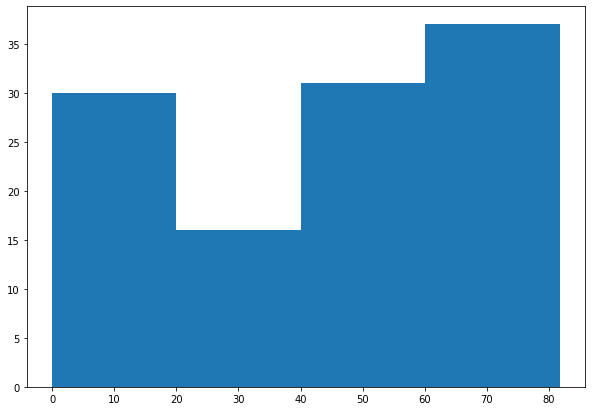

In [12]:
fig,ax = plt.subplots(figsize =(10, 7))
ax.hist(df2['zero_count'], bins = [0,20, 40, 60, 81.74])

The histogram has been divided in 4 bins & clearly shows 37 values still has 60% zeroes, these can be dropped.

## Lets analyze part 3 of the histogram

(array([ 4.,  0., 13., 14.]),
 array([40, 45, 50, 55, 60]),
 <BarContainer object of 4 artists>)

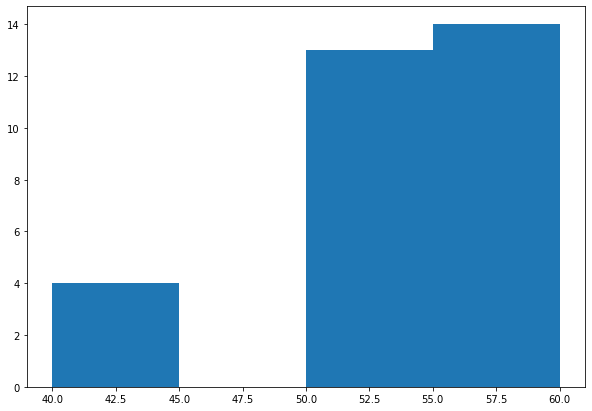

In [14]:
df3 = df2[(df2.zero_count >= 40) & (df2.zero_count <= 60)]
fig,ax = plt.subplots(figsize =(10, 7))
ax.hist(df3['zero_count'], bins = [40,45,50,55,60])

There are around 27 rows having zeroes, which is greater than 50% of the data as the total datapoints were 206. we chose the threshold of 50.

In [15]:
print(df2[(df2.zero_count >= 0) & (df2.zero_count < 20)].count()['Part No']) ,
print(df2[(df2.zero_count >= 20) & (df2.zero_count < 40)].count()['Part No']),
print(df2[(df2.zero_count >= 40) & (df2.zero_count <= 50)].count()['Part No'])

30
16
4


In [16]:
df3 = df2[(df2.zero_count < 50)]

In [17]:
df3.shape

(50, 208)

The data is for 50 parts & 206 weeks, starting JAN 2016 to Dec 2020.

There are no missing values, I'll check sales for outliers.

## Outlier Check

Time for an outlier check!

For outlier detection, I will use IQR method with Q1 as 0.05% and Q3 as 0.95%. I will compute the low limit and up limit with IQR method and check if the sales variable contain values above/below these limits. It will return boolean.

In [18]:
tdf = df3.T
tdf.columns = tdf.iloc[0]
tdf = tdf[1:]

In [ ]:
tdf.head(1)

In [19]:
def outlier_thresholds(dataframe, col_name, q1_perc=0.05, q3_perc=0.95):
    """
    given dataframe, column name, q1_percentage and q3 percentage, function calculates low_limit and up_limit

    """
    quartile1 = dataframe[col_name].quantile(q1_perc)
    quartile3 = dataframe[col_name].quantile(q3_perc)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name, q1_perc=0.01, q3_perc=0.99):
    outlier_list = []
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1_perc=0.01, q3_perc=0.99)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True

    else:
        return False

# def clip_outlier():
#     low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1_perc=0.01, q3_perc=0.99)
#     if dataframe[(dataframe[col_name] > up_limit):
#                  [col_name]
#     df.clip(lower=0, upper=1, inplace=True)


In [20]:
tdf1 = tdf.iloc[:,0:].apply(pd.to_numeric, errors='coerce')

In [ ]:
tdf.head(1)

In [ ]:
tdf1.dtypes

In [21]:
for m in tdf1.columns[1:]:
    print(m,check_outlier(tdf1,m))

29032635 False
29032793 False
29032794 False
29032588DL False
29032587DL False
29032639 False
29032640 False
29032815 False
29032814 False
29032527DL False
29032526DL False
29032751 False
29032752 False
29032787 False
29032788 False
29033027DR False
29032341FI False
29032342FI False
67033499 False
67033500 False
29032295DR False
29032296DR False
32042192 False
29032507 False
29032508 False
29032651DF False
29032652DF False
29032875 False
29032874 False
29032282BD False
29032281BD False
29032842 False
29032841 False
29032900 False
29032901 False
29032724 False
29032723 False
29032803 False
29032802 False
29032615DL False
29032616DL False
29032671 False
29032997 False
29032996 False
29032797 False
29032798 False
67032868 False
67032869 False
29932192 False


Rule validates that no outliers are present in the dataframe

## Time Series Decomposition
It is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns

<Figure size 432x288 with 0 Axes>

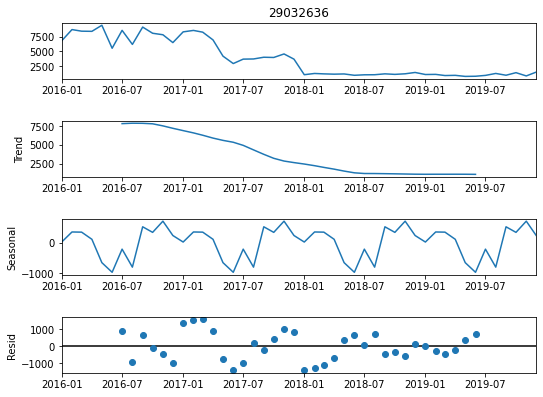

<Figure size 432x288 with 0 Axes>

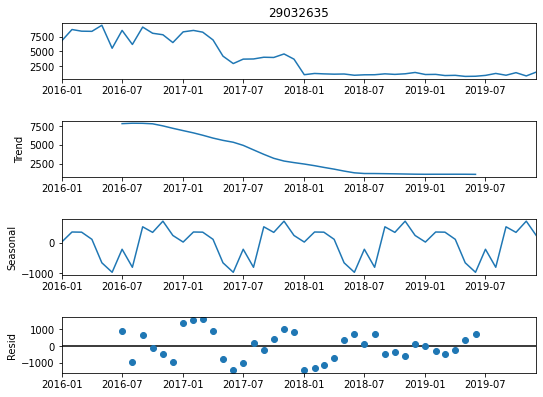

<Figure size 432x288 with 0 Axes>

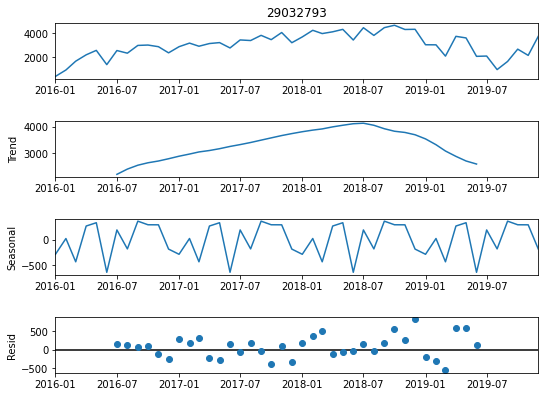

<Figure size 432x288 with 0 Axes>

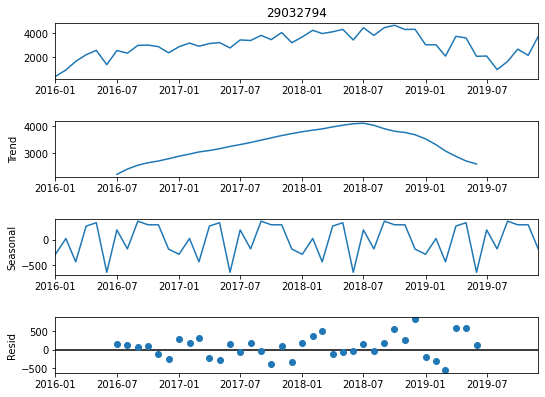

<Figure size 432x288 with 0 Axes>

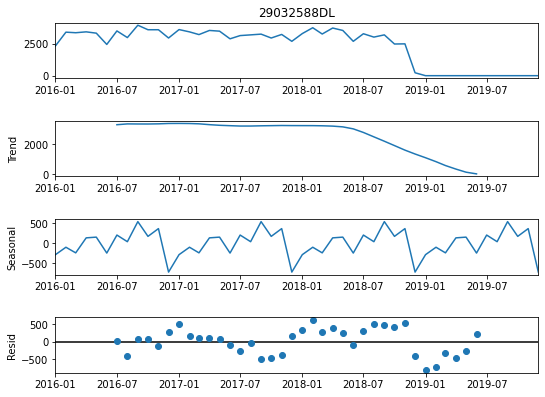

<Figure size 432x288 with 0 Axes>

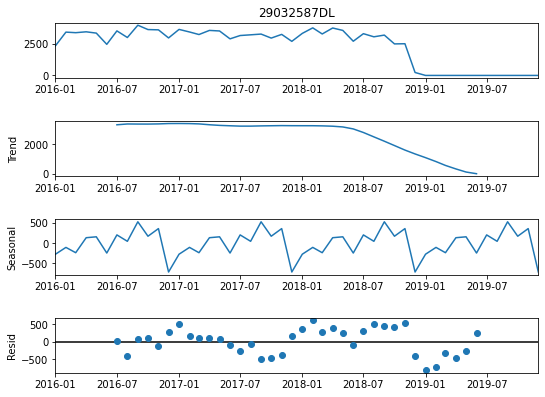

<Figure size 432x288 with 0 Axes>

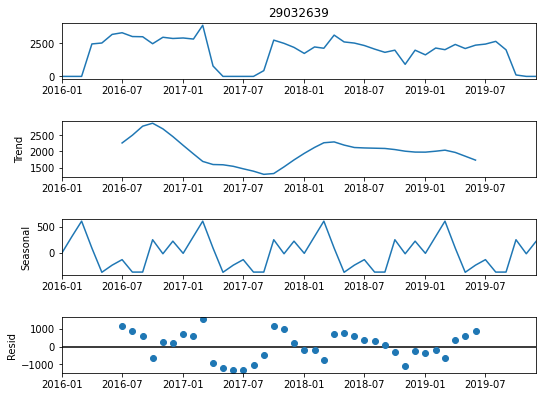

<Figure size 432x288 with 0 Axes>

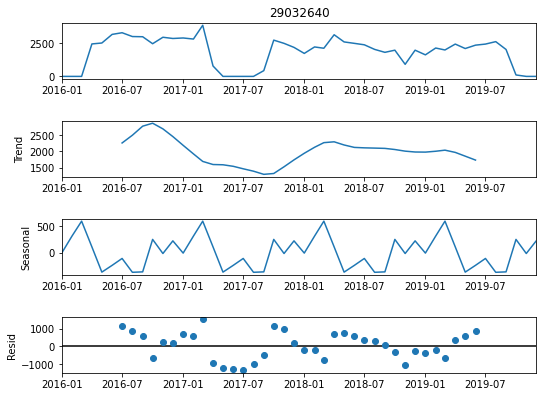

<Figure size 432x288 with 0 Axes>

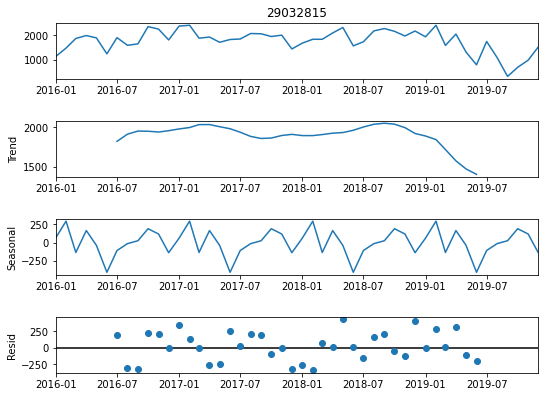

<Figure size 432x288 with 0 Axes>

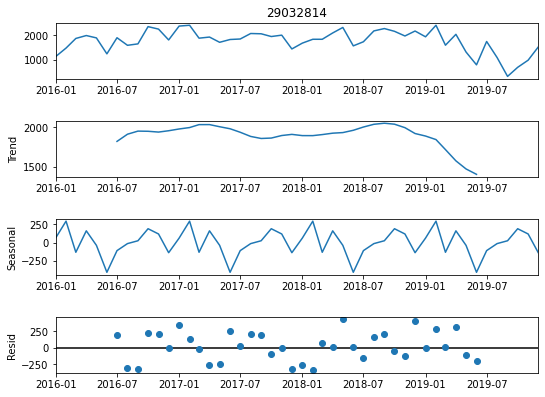

<Figure size 432x288 with 0 Axes>

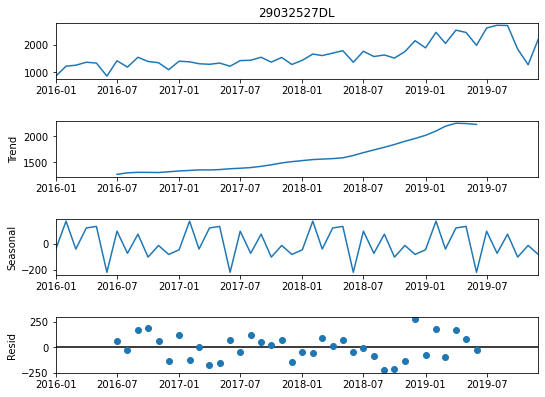

<Figure size 432x288 with 0 Axes>

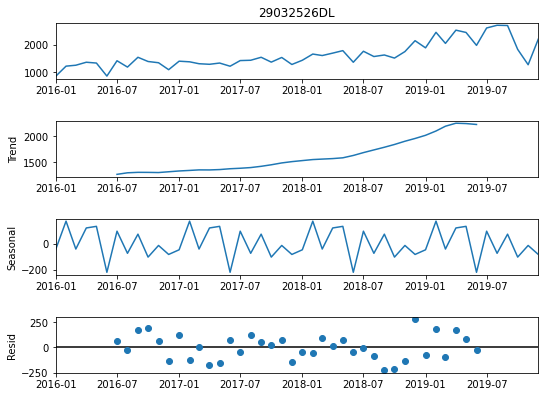

<Figure size 432x288 with 0 Axes>

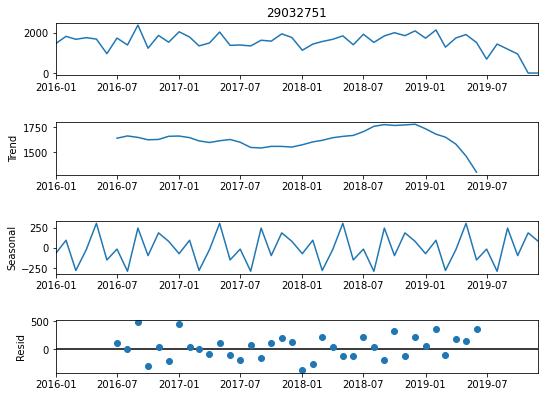

<Figure size 432x288 with 0 Axes>

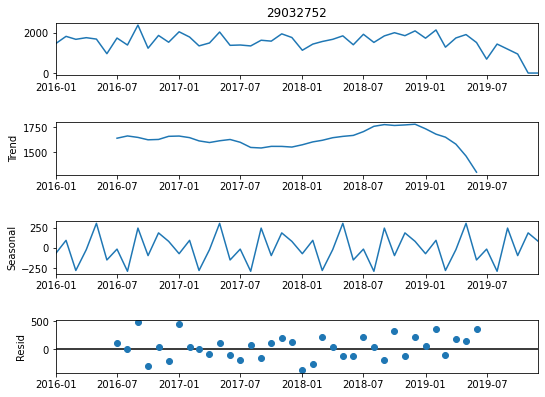

<Figure size 432x288 with 0 Axes>

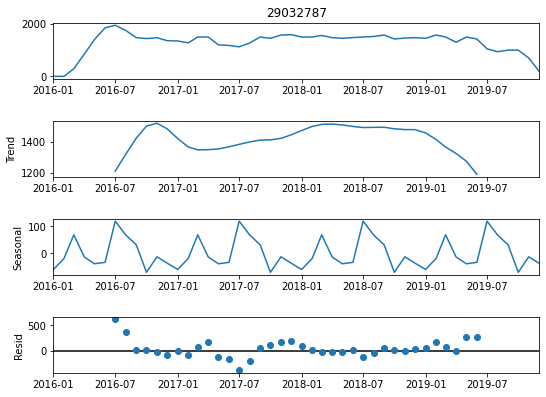

<Figure size 432x288 with 0 Axes>

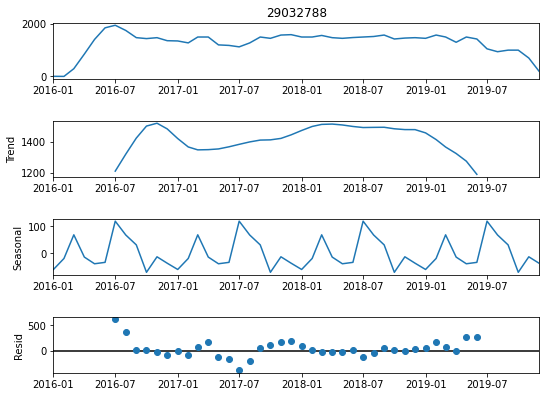

<Figure size 432x288 with 0 Axes>

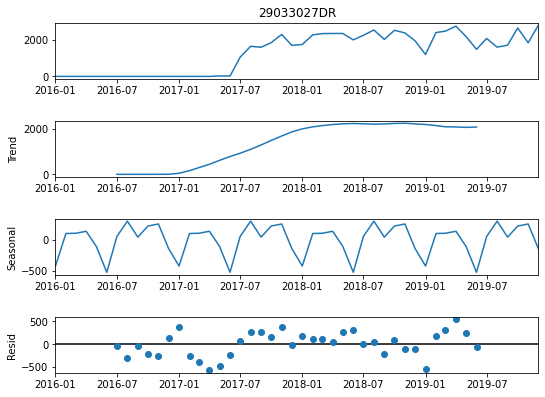

<Figure size 432x288 with 0 Axes>

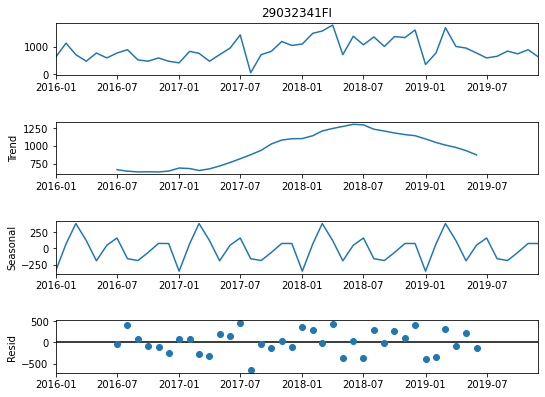

<Figure size 432x288 with 0 Axes>

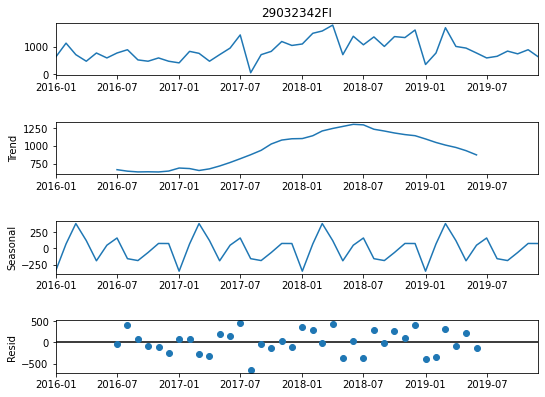

<Figure size 432x288 with 0 Axes>

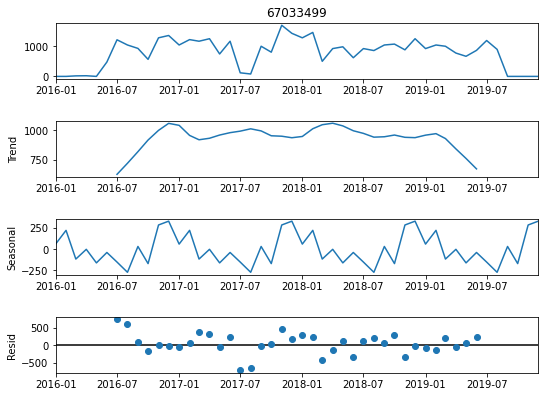

<Figure size 432x288 with 0 Axes>

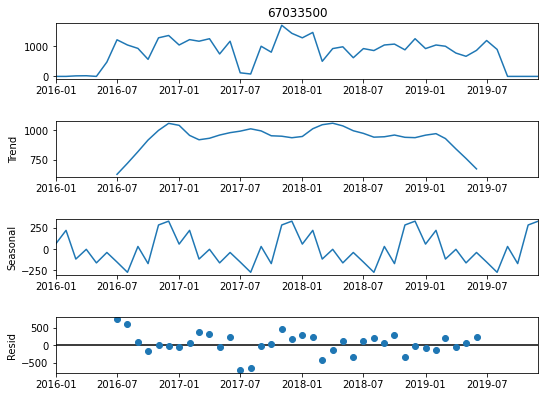

<Figure size 432x288 with 0 Axes>

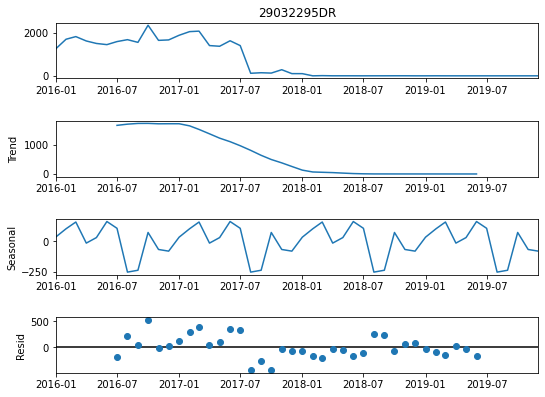

<Figure size 432x288 with 0 Axes>

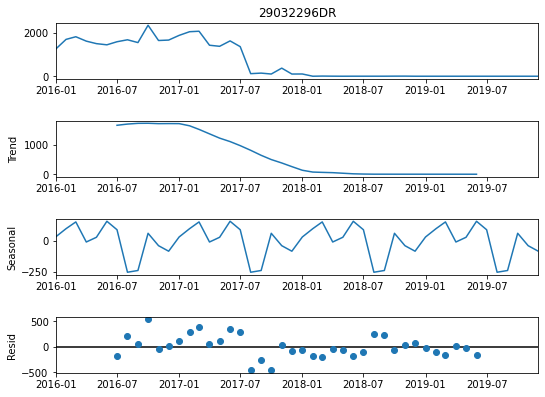

<Figure size 432x288 with 0 Axes>

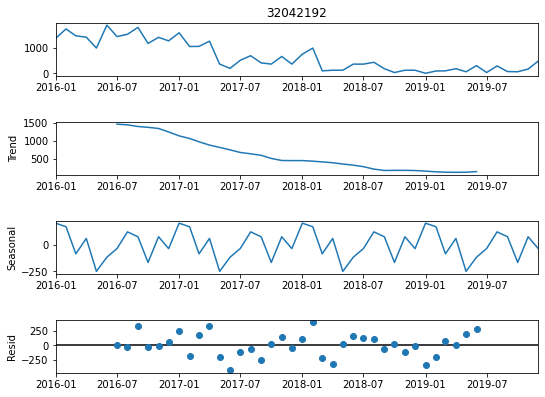

<Figure size 432x288 with 0 Axes>

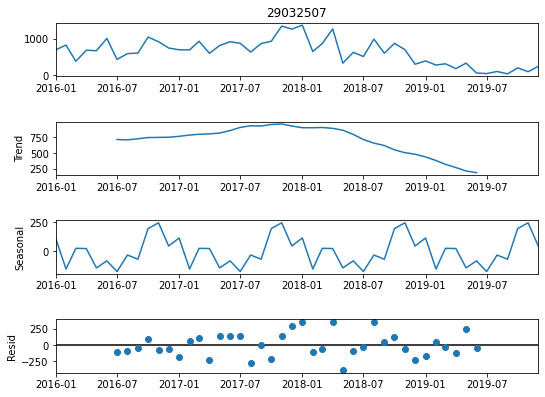

<Figure size 432x288 with 0 Axes>

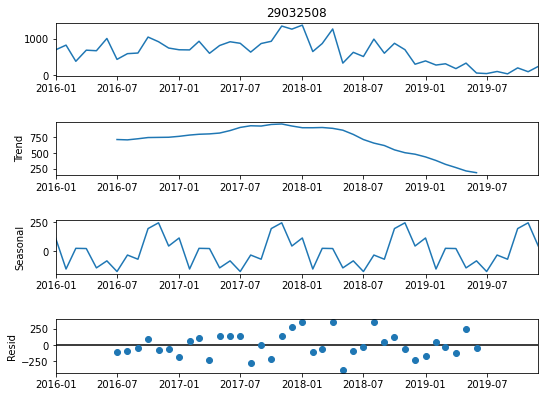

<Figure size 432x288 with 0 Axes>

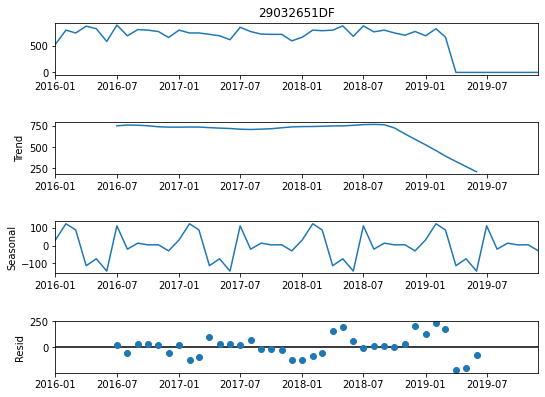

<Figure size 432x288 with 0 Axes>

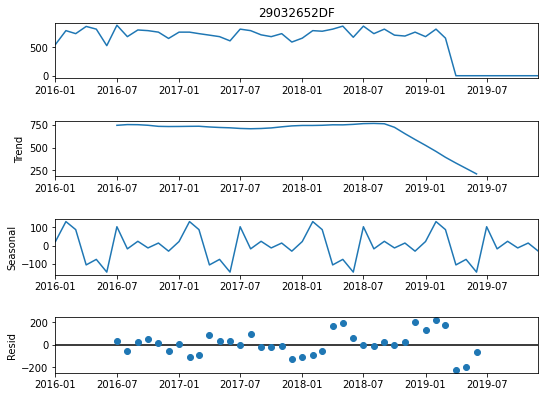

<Figure size 432x288 with 0 Axes>

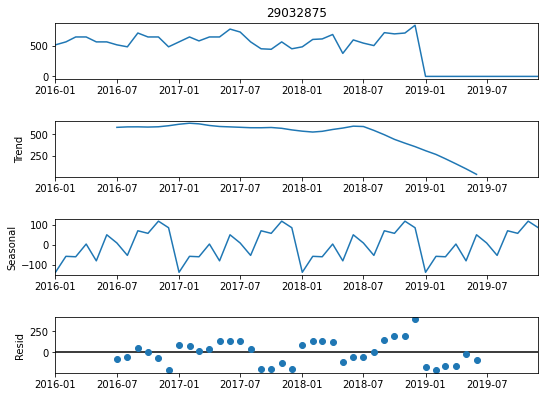

<Figure size 432x288 with 0 Axes>

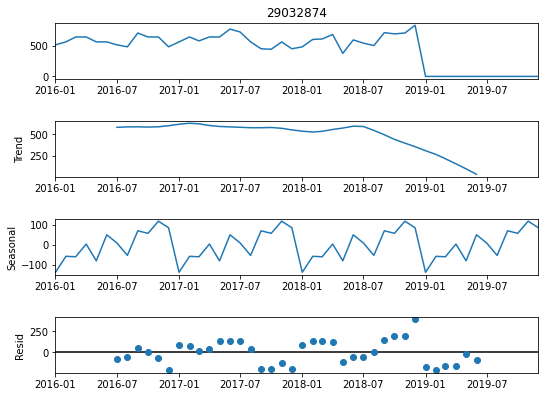

<Figure size 432x288 with 0 Axes>

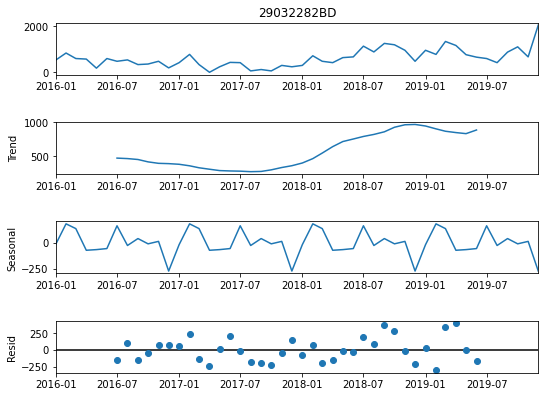

<Figure size 432x288 with 0 Axes>

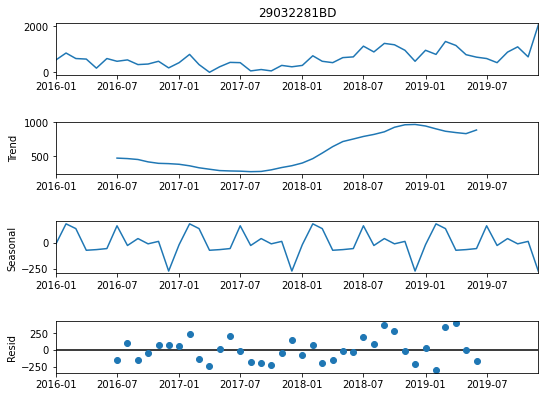

<Figure size 432x288 with 0 Axes>

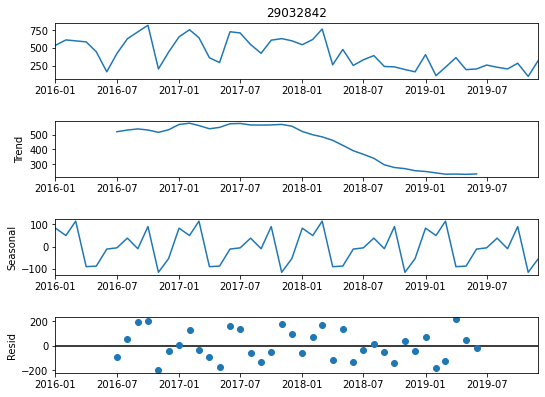

<Figure size 432x288 with 0 Axes>

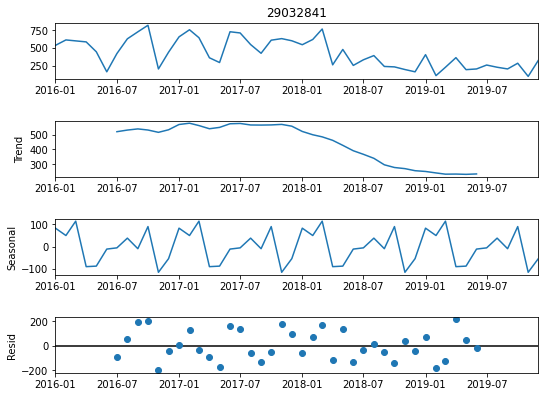

<Figure size 432x288 with 0 Axes>

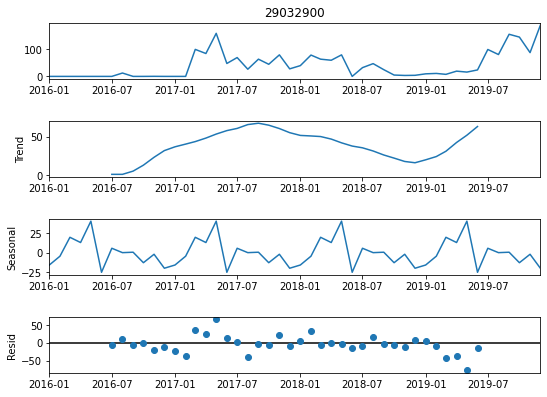

<Figure size 432x288 with 0 Axes>

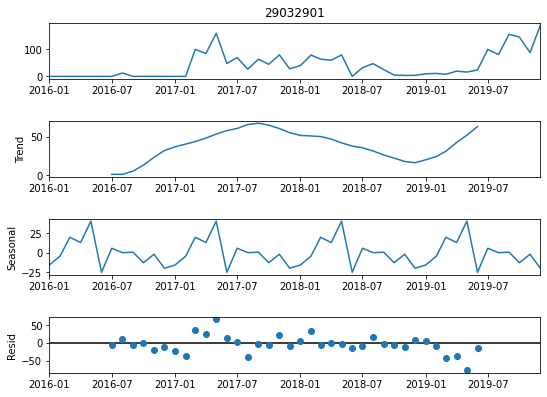

<Figure size 432x288 with 0 Axes>

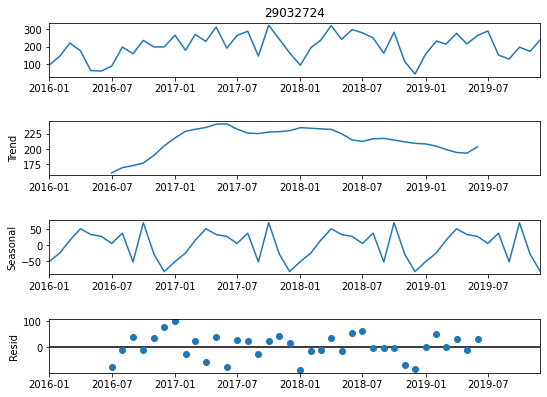

<Figure size 432x288 with 0 Axes>

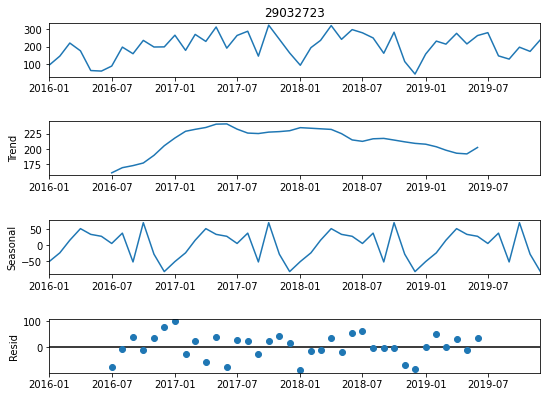

<Figure size 432x288 with 0 Axes>

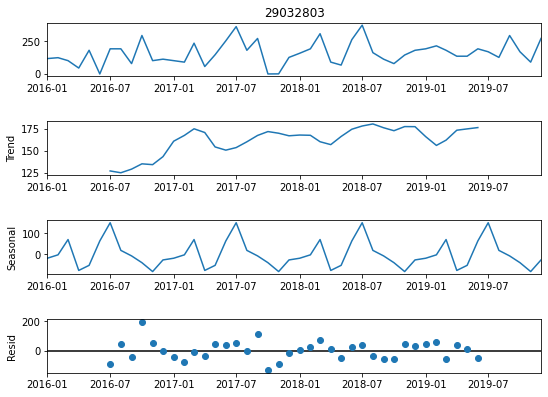

<Figure size 432x288 with 0 Axes>

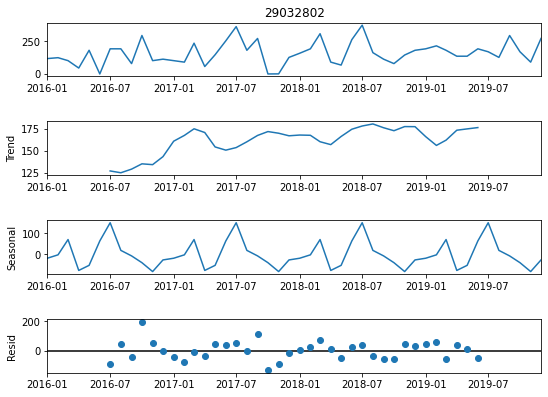

<Figure size 432x288 with 0 Axes>

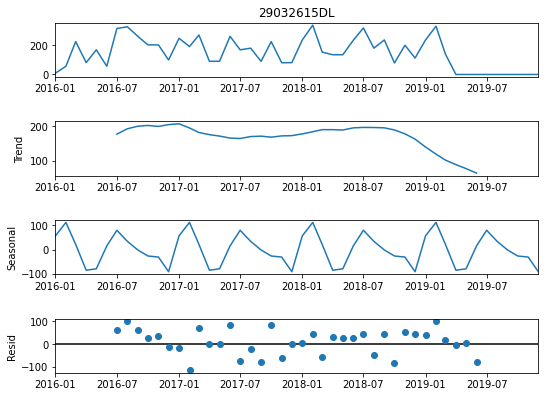

<Figure size 432x288 with 0 Axes>

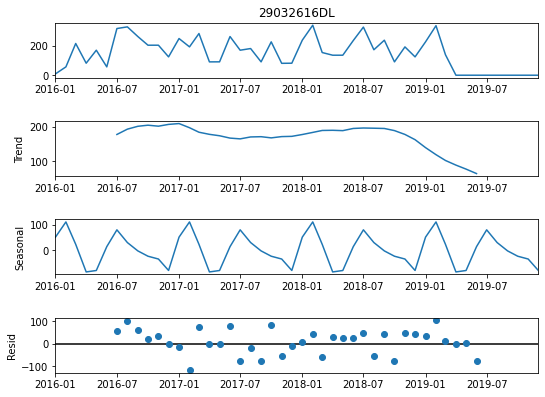

<Figure size 432x288 with 0 Axes>

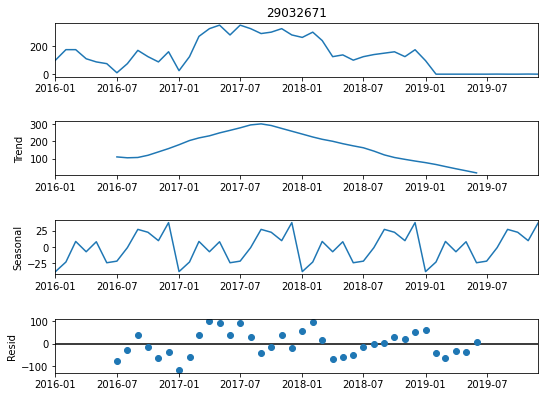

<Figure size 432x288 with 0 Axes>

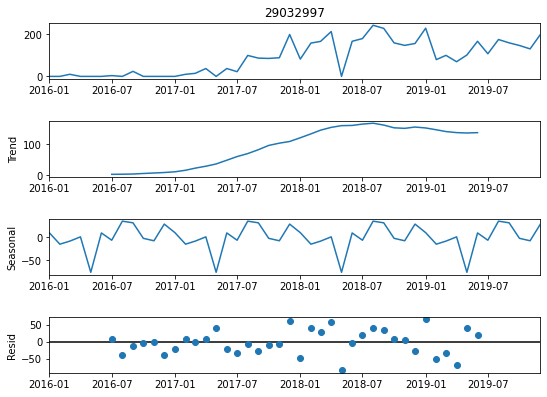

<Figure size 432x288 with 0 Axes>

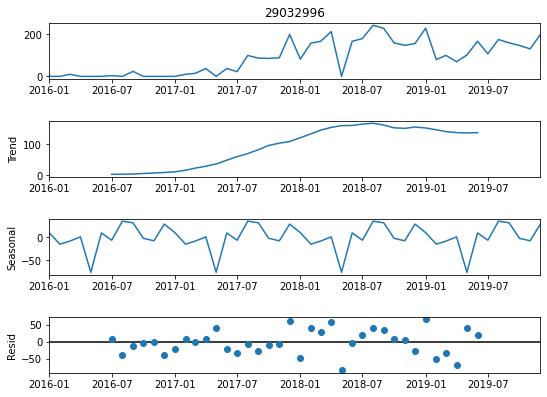

<Figure size 432x288 with 0 Axes>

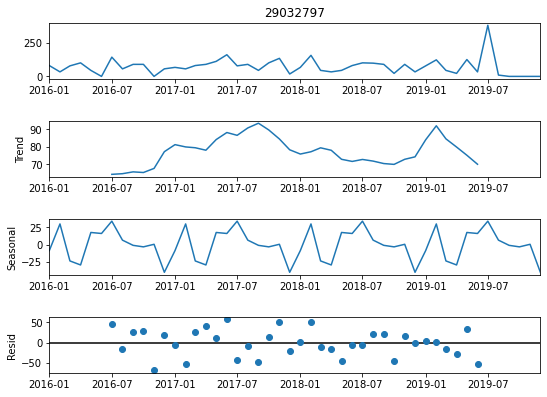

<Figure size 432x288 with 0 Axes>

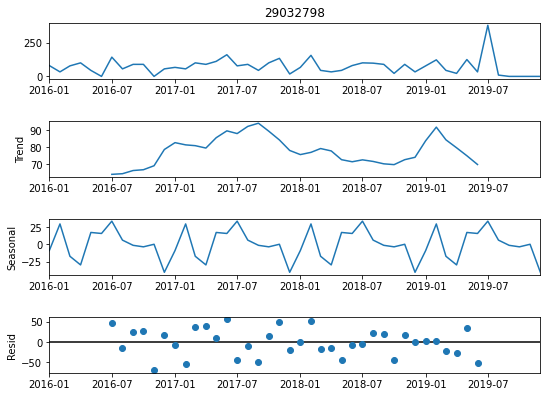

<Figure size 432x288 with 0 Axes>

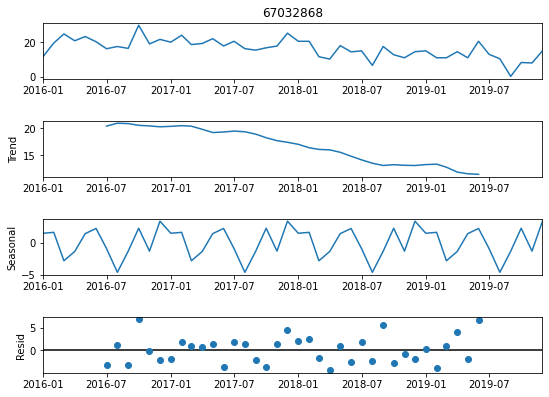

<Figure size 432x288 with 0 Axes>

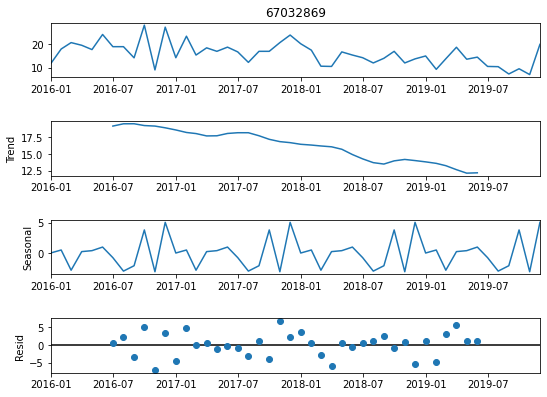

<Figure size 432x288 with 0 Axes>

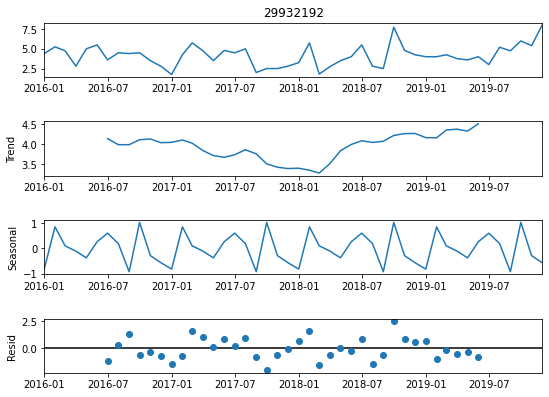

In [22]:
tdf2 = tdf1.reset_index()
tdf2 = tdf2.drop([206]).rename(columns = {'index':('date')})
tdf2['date'] = pd.to_datetime(tdf2['date'])
tdf2 = tdf2.set_index('date')

for m in tdf2.columns:
    y = tdf2[m].resample('MS').mean() 

    result = sm.tsa.seasonal_decompose(y, model='additive')
    fig = plt.figure()  
    fig = result.plot()  
    fig.set_size_inches(8, 6)


## Feature Engineering
In order to search for seasonalities, date variable will be used to derive new features and different time periods will be created.

In [23]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['week_of_year'] = df.date.dt.weekofyear
    # 1.1.2013 is Tuesday, so our starting point is the 2nd day of week
    df['year'] = df.date.dt.year
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

In [24]:
tdf3 =tdf2.reset_index().fillna(0)

In [25]:
create_date_features(tdf3)

Part No       date  29032636  29032635  29032793  29032794  29032588DL  \
0       2016-01-01     432.0     432.0      28.0      28.0       180.0   
1       2016-01-08    9316.0    9316.0     420.0     420.0      3195.0   
2       2016-01-15    8964.0    8964.0     532.0     532.0      3240.0   
3       2016-01-22    9000.0    9000.0     560.0     560.0      2970.0   
4       2016-01-29    6264.0    6192.0     448.0     448.0      2160.0   
..             ...       ...       ...       ...       ...         ...   
201     2019-11-08     180.0     180.0     480.0     480.0         0.0   
202     2019-11-15    1404.0    1404.0    3432.0    3432.0         0.0   
203     2019-11-22    1332.0    1332.0    3504.0    3505.0         0.0   
204     2019-11-29     972.0     972.0    2280.0    2280.0         0.0   
205     2019-12-06    1512.0    1512.0    3744.0    3744.0         0.0   

Part No  29032587DL  29032639  29032640  29032815  ...  29032797  29032798  \
0             135.0       0.0       0.0      45.0  ...       0.0       0.0   
1            3240.0       0.0       0.0    1440.0  ...     180.0     180.0   
2            3240.0       0.0       0.0    1440.0  ...     135.0     135.0   
3            2970.0       0.0       0.0    1620.0  ...      90.0      90.0   
4            2160.0       0.0       0.0    1125.0  ...       0.0       0.0   
..              ...       ...       ...       ...  ...       ...       ...   
201             0.0       0.0       0.0     225.0  ...       0.0       0.0   
202             0.0       0.0       0.0    1575.0  ...       0.0       0.0   
203             0.0       0.0       0.0    1575.0  ...       0.0       0.0   
204             0.0       0.0       0.0     945.0  ...       0.0       0.0   
205             0.0       0.0       0.0    1530.0  ...       0.0       0.0   

Part No  67032868  67032869  29932192  month  week_of_year  year  \
0             0.0       0.0       0.0      1            53  2016   
1            19.0      17.0       7.0      1             1  2016   
2             3.0      10.0       5.0      1             2  2016   
3            18.0      15.0       8.0      1             3  2016   
4            18.0      16.0       2.0      1             4  2016   
..            ...       ...       ...    ...           ...   ...   
201           0.0       0.0       0.0     11            45  2019   
202          12.0      11.0       3.0     11            46  2019   
203          14.0      10.0      10.0     11            47  2019   
204          10.0       9.0      12.0     11            48  2019   
205          15.0      20.0       8.0     12            49  2019   

Part No  is_month_start  is_month_end  
0                     1             0  
1                     0             0  
2                     0             0  
3                     0             0  
4                     0             0  
..                  ...           ...  
201                   0             0  
202                   0             0  
203                   0             0  
204                   0             0  
205                   0             0  

[206 rows x 56 columns]

In [ ]:
tdf3.to_csv('tdf3.csv')

## Applying AutoRegression

In [26]:
def autoregression(m):
    
    X = tdf3[[m]].values
    # X = series.values
    train, test = X[1:len(X)-12], X[len(X)-12:]
    # train autoregression
    model = AutoReg(train, lags=20)
    model_fit = model.fit()
    print('Coefficients: %s' % model_fit.params)
    # make predictions
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    for i in range(len(predictions)):
        print('predicted=%f, expected=%f' % (predictions[i], test[i]))
    rmse = sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    w_mape = abs((predictions-test).sum())*100/test.sum(axis=0)
    print('Test WMAPE:',w_mape)
    # plot results
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')
    pyplot.show()
    return w_mape[0]



Coefficients: [ 1.05165165e+01  4.67168723e-01  2.38292958e-02  7.18781000e-02
  1.24480945e-01 -1.53500018e-02  9.60454583e-02  7.72059073e-04
  1.23011667e-01 -4.37610791e-02  8.39314867e-02  2.01966629e-01
 -2.77219159e-01  3.51786399e-02 -1.75859980e-02  4.52814792e-03
 -7.89149495e-02 -9.63783009e-02  8.10643724e-02  1.91919740e-01
 -3.02223895e-02]
predicted=1393.180935, expected=972.000000
predicted=1114.363975, expected=1116.000000
predicted=1074.715737, expected=1512.000000
predicted=974.415124, expected=1512.000000
predicted=1186.009654, expected=1260.000000
predicted=1320.907379, expected=1369.000000
predicted=840.005021, expected=432.000000
predicted=981.997940, expected=180.000000
predicted=1004.026063, expected=1404.000000
predicted=759.995734, expected=1332.000000
predicted=950.254850, expected=972.000000
predicted=958.371635, expected=1512.000000
Test RMSE: 434.858
Test WMAPE: [89.71540152]


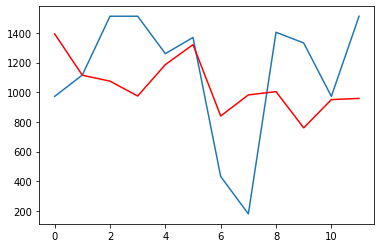

Coefficients: [ 1.06301257e+01  4.68408533e-01  2.32944656e-02  7.17176716e-02
  1.24022469e-01 -1.58398549e-02  9.78741535e-02 -5.71408372e-04
  1.23973574e-01 -4.34046514e-02  8.26468786e-02  2.01652888e-01
 -2.76805581e-01  3.53079224e-02 -1.73074670e-02  3.94163218e-03
 -7.94537303e-02 -9.66792514e-02  8.24732812e-02  1.92824261e-01
 -3.16729997e-02]
predicted=1394.511402, expected=972.000000
predicted=1113.352055, expected=1116.000000
predicted=1075.289848, expected=1512.000000
predicted=975.717060, expected=1512.000000
predicted=1185.607264, expected=1260.000000
predicted=1323.253393, expected=1368.000000
predicted=840.591033, expected=432.000000
predicted=980.074886, expected=180.000000
predicted=1005.376466, expected=1404.000000
predicted=760.658148, expected=1332.000000
predicted=950.462023, expected=972.000000
predicted=959.429102, expected=1512.000000
Test RMSE: 434.221
Test WMAPE: [89.09613794]


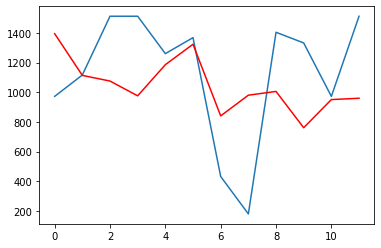

Coefficients: [ 3.83610074e+02  2.12465267e-01  1.04866566e-01  1.71663177e-01
  6.60952428e-02  6.57692590e-02 -2.14722543e-03  5.75850843e-02
  9.73655218e-02  6.49214286e-02  3.69638913e-02  1.08590418e-01
 -1.38946699e-01 -8.13101348e-02 -5.59102118e-02 -6.67797979e-03
 -3.39011125e-02  1.07082662e-01 -2.60123468e-03  1.39757441e-01
 -3.47381452e-02]
predicted=2062.512480, expected=1704.000000
predicted=1942.359792, expected=2424.000000
predicted=1941.139868, expected=2832.000000
predicted=1991.741158, expected=2928.000000
predicted=1983.457240, expected=2400.000000
predicted=1586.165449, expected=2520.000000
predicted=1729.631797, expected=1056.000000
predicted=1735.846485, expected=480.000000
predicted=2356.151361, expected=3432.000000
predicted=2328.032538, expected=3504.000000
predicted=2420.964438, expected=2280.000000
predicted=2509.014893, expected=3744.000000
Test RMSE: 875.244
Test WMAPE: [193.16062661]


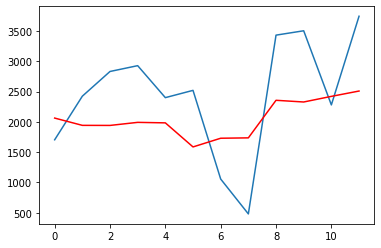

Coefficients: [ 3.83119287e+02  2.12707735e-01  1.04914672e-01  1.70460537e-01
  6.67894302e-02  6.57348205e-02 -1.53936457e-03  5.71124320e-02
  9.75135492e-02  6.44890960e-02  3.64820696e-02  1.10308246e-01
 -1.38762969e-01 -8.20817382e-02 -5.58804015e-02 -6.94750773e-03
 -3.33788290e-02  1.07188649e-01 -1.99601038e-03  1.38958034e-01
 -3.50493644e-02]
predicted=2064.076617, expected=1704.000000
predicted=1943.729389, expected=2424.000000
predicted=1938.456299, expected=2832.000000
predicted=1989.036593, expected=2928.000000
predicted=1981.709158, expected=2400.000000
predicted=1585.311855, expected=2520.000000
predicted=1725.702987, expected=1056.000000
predicted=1734.496016, expected=480.000000
predicted=2355.277373, expected=3432.000000
predicted=2325.718467, expected=3505.000000
predicted=2419.852789, expected=2280.000000
predicted=2507.522822, expected=3744.000000
Test RMSE: 876.058
Test WMAPE: [193.85536805]


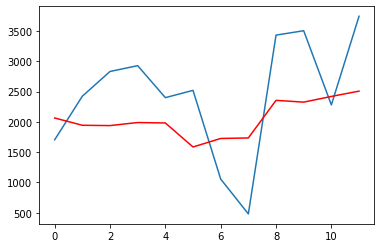

Coefficients: [-6.45472345  0.20122593  0.13885919  0.21827927  0.14668715  0.05807779
 -0.06451372  0.07506315  0.08870582  0.1775448   0.106655    0.11202199
 -0.16656006 -0.06937614 -0.08493025  0.08004078 -0.01151903 -0.01899839
 -0.03936611  0.07826789 -0.04840044]
predicted=-6.454723, expected=0.000000
predicted=-7.753581, expected=0.000000
predicted=-8.911243, expected=0.000000
predicted=-10.733485, expected=0.000000
predicted=-12.491258, expected=0.000000
predicted=-13.916098, expected=0.000000
predicted=-14.673484, expected=0.000000
predicted=-16.142679, expected=0.000000
predicted=-17.813559, expected=0.000000
predicted=-20.060767, expected=0.000000
predicted=-22.304634, expected=0.000000
predicted=-24.961224, expected=0.000000
Test RMSE: 15.712
Test WMAPE: [inf]


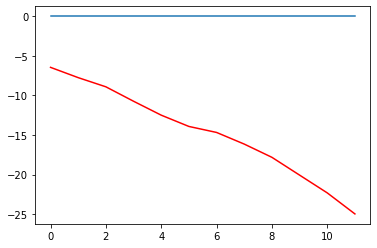

Coefficients: [-6.52407676  0.20243216  0.14358824  0.21421355  0.14229682  0.06036683
 -0.06225573  0.07497772  0.08744162  0.17068804  0.11203983  0.10918441
 -0.16289598 -0.0690367  -0.08361095  0.08016804 -0.01688641 -0.01675516
 -0.03731632  0.08117341 -0.05197435]
predicted=-6.524077, expected=0.000000
predicted=-7.844760, expected=0.000000
predicted=-9.048889, expected=0.000000
predicted=-10.879824, expected=0.000000
predicted=-12.634626, expected=0.000000
predicted=-14.092463, expected=0.000000
predicted=-14.876664, expected=0.000000
predicted=-16.360809, expected=0.000000
predicted=-18.040902, expected=0.000000
predicted=-20.280837, expected=0.000000
predicted=-22.582737, expected=0.000000
predicted=-25.255511, expected=0.000000
Test RMSE: 15.906
Test WMAPE: [inf]


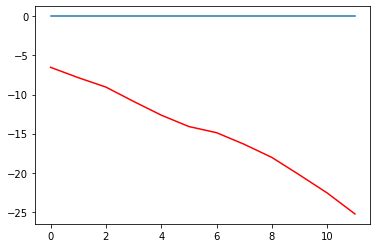

Coefficients: [ 5.80141578e+02  4.25450258e-01  4.63176085e-02  1.77527904e-01
 -3.02305481e-02  1.75161201e-01 -5.90255319e-02  7.16756548e-02
  4.04185362e-02  1.87244547e-02 -3.63457067e-02 -2.09184219e-02
  4.41449799e-02 -9.17828643e-02 -4.17886070e-02  5.15884046e-02
  4.47124492e-02 -3.18767242e-02 -5.18530613e-03 -1.38758494e-02
 -5.32852555e-02]
predicted=1872.526477, expected=2376.000000
predicted=2095.171421, expected=2268.000000
predicted=1991.132028, expected=432.000000
predicted=1986.484816, expected=0.000000
predicted=1892.257646, expected=0.000000
predicted=1942.991372, expected=0.000000
predicted=1839.680374, expected=0.000000
predicted=1765.586639, expected=0.000000
predicted=1895.097496, expected=0.000000
predicted=1882.889448, expected=0.000000
predicted=1838.869391, expected=0.000000
predicted=1828.593259, expected=0.000000
Test RMSE: 1692.626
Test WMAPE: [4197.46580763]


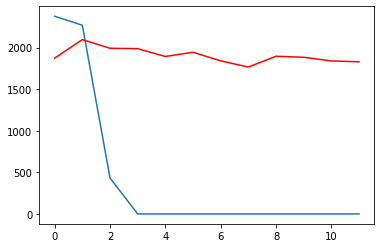

Coefficients: [ 5.79006456e+02  4.28141696e-01  5.04599020e-02  1.66036355e-01
 -2.02200290e-02  1.69986222e-01 -6.17143546e-02  7.59291168e-02
  4.32393564e-02  5.47645255e-03 -2.46239068e-02 -2.66216846e-02
  5.47660079e-02 -1.03300394e-01 -3.44026986e-02  4.08467106e-02
  5.57061201e-02 -2.19229622e-02 -2.33348548e-02 -1.07531144e-02
 -5.15896552e-02]
predicted=1872.521985, expected=2376.000000
predicted=2116.937982, expected=2268.000000
predicted=2006.355050, expected=432.000000
predicted=2001.893119, expected=0.000000
predicted=1910.382174, expected=0.000000
predicted=1937.022959, expected=0.000000
predicted=1859.299149, expected=0.000000
predicted=1772.531043, expected=0.000000
predicted=1933.052595, expected=0.000000
predicted=1893.633839, expected=0.000000
predicted=1842.037362, expected=0.000000
predicted=1836.420699, expected=0.000000
Test RMSE: 1704.187
Test WMAPE: [4233.11772007]


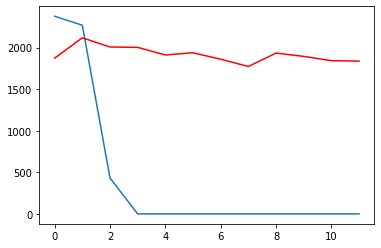

Coefficients: [ 5.40296512e+02  2.00160219e-01  2.45742870e-02  1.38499755e-01
  1.81732382e-02  5.41184625e-02 -1.37571390e-02 -4.74283749e-02
  1.59391238e-01  4.55883137e-03  7.86478675e-02  1.34345043e-01
 -7.43104395e-02  9.85333235e-03 -3.86124521e-02  1.67738942e-01
 -6.27576779e-02 -4.67433513e-03 -7.10305650e-02  4.33579381e-02
 -2.24571424e-02]
predicted=1483.873422, expected=270.000000
predicted=1271.868870, expected=90.000000
predicted=1369.501665, expected=270.000000
predicted=1224.656327, expected=585.000000
predicted=1618.238827, expected=495.000000
predicted=1406.998430, expected=1440.000000
predicted=1366.744378, expected=630.000000
predicted=1242.537034, expected=225.000000
predicted=1587.497749, expected=1575.000000
predicted=1288.418612, expected=1575.000000
predicted=1272.243405, expected=945.000000
predicted=1504.910085, expected=1530.000000
Test RMSE: 791.586
Test WMAPE: [873.2073276]


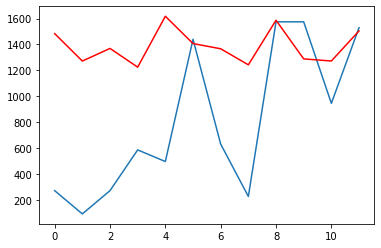

Coefficients: [ 5.44698216e+02  1.97155005e-01  2.61800121e-02  1.38004245e-01
  2.20421605e-02  5.25245117e-02 -1.32767638e-02 -4.82671566e-02
  1.60206253e-01  5.21453988e-03  8.03147384e-02  1.30604777e-01
 -7.34012340e-02  6.35999778e-03 -3.87343442e-02  1.68673989e-01
 -5.88830174e-02 -4.04846647e-03 -7.16905104e-02  4.11644047e-02
 -2.40846200e-02]
predicted=1481.009582, expected=270.000000
predicted=1276.941712, expected=90.000000
predicted=1364.531623, expected=270.000000
predicted=1218.217042, expected=585.000000
predicted=1616.568712, expected=495.000000
predicted=1409.278083, expected=1440.000000
predicted=1372.675632, expected=630.000000
predicted=1247.560468, expected=225.000000
predicted=1591.652569, expected=1575.000000
predicted=1293.137751, expected=1575.000000
predicted=1277.732302, expected=945.000000
predicted=1502.513930, expected=1530.000000
Test RMSE: 791.706
Test WMAPE: [874.99307244]


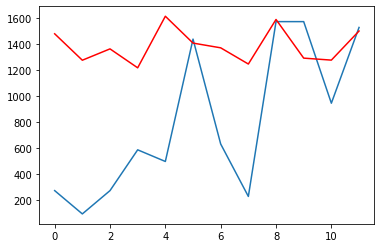

Coefficients: [-1.12164017e+02  6.62478854e-02 -1.14230281e-02  7.93363799e-02
 -6.85080106e-03  3.89590608e-03 -1.18816110e-02  1.33548647e-01
  2.08723926e-01 -1.39762683e-02  1.88680709e-01  2.19461475e-01
  1.53868608e-02  7.86062112e-02  4.56744373e-02  5.79461015e-02
 -6.51422257e-02  8.41412871e-02 -1.72315140e-02  8.05883621e-02
 -1.94942350e-02]
predicted=2914.555916, expected=3060.000000
predicted=2766.173691, expected=2745.000000
predicted=2634.850846, expected=2295.000000
predicted=2619.276021, expected=2205.000000
predicted=3195.685975, expected=1530.000000
predicted=2620.293412, expected=1350.000000
predicted=2545.552991, expected=585.000000
predicted=2947.144253, expected=315.000000
predicted=2901.639421, expected=1935.000000
predicted=2735.986374, expected=2160.000000
predicted=2959.088395, expected=1395.000000
predicted=3095.879721, expected=2205.000000
Test RMSE: 1290.188
Test WMAPE: [669.75906431]


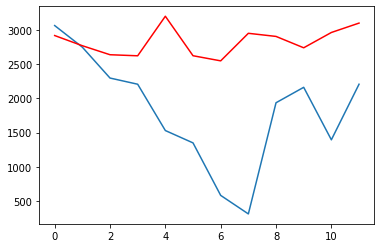

Coefficients: [-1.12372910e+02  6.74123001e-02 -1.07053799e-02  7.98982414e-02
 -9.11369867e-03  9.07240611e-03 -1.66262031e-02  1.33295033e-01
  2.11637395e-01 -1.76741186e-02  1.89186906e-01  2.19349820e-01
  1.39095588e-02  8.00821517e-02  4.49595096e-02  5.88299804e-02
 -6.83821739e-02  8.68034892e-02 -2.06433865e-02  8.65324043e-02
 -2.14980086e-02]
predicted=2905.449289, expected=3060.000000
predicted=2763.593987, expected=2745.000000
predicted=2649.286175, expected=2250.000000
predicted=2600.648606, expected=2205.000000
predicted=3204.792811, expected=1530.000000
predicted=2628.380397, expected=1352.000000
predicted=2543.860507, expected=585.000000
predicted=2940.916458, expected=315.000000
predicted=2899.588581, expected=1935.000000
predicted=2745.382641, expected=2160.000000
predicted=2948.538614, expected=1395.000000
predicted=3094.638419, expected=2205.000000
Test RMSE: 1290.507
Test WMAPE: [672.8477611]


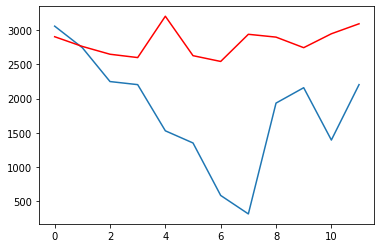

Coefficients: [ 1.43020349e+03  3.05450780e-01 -3.33479878e-02  1.34246758e-01
 -1.24149670e-01 -2.04989823e-02 -9.57214038e-02  3.60536927e-02
 -4.83029273e-02 -1.43012837e-02  8.58319828e-02  7.99575343e-02
 -1.50247154e-01 -4.37301866e-02 -8.19353457e-02  3.72664602e-02
 -4.05918653e-02  5.57327191e-02  9.49214036e-02  4.87290896e-02
 -1.05758277e-01]
predicted=1767.204541, expected=945.000000
predicted=1876.267341, expected=1125.000000
predicted=1993.411397, expected=1305.000000
predicted=1894.126391, expected=1395.000000
predicted=2060.625501, expected=991.000000
predicted=1757.635550, expected=64.000000
predicted=1383.432937, expected=0.000000
predicted=1385.913510, expected=0.000000
predicted=1528.406864, expected=0.000000
predicted=1524.910449, expected=0.000000
predicted=1584.461562, expected=0.000000
predicted=1695.377129, expected=0.000000
Test RMSE: 1286.365
Test WMAPE: [3013.24082494]


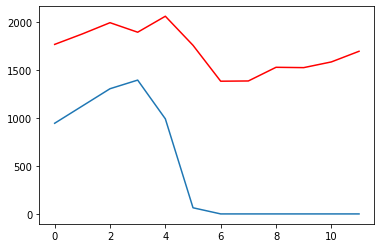

Coefficients: [ 1.43107783e+03  3.05193660e-01 -3.29441102e-02  1.34005161e-01
 -1.24100872e-01 -2.06747053e-02 -9.53145614e-02  3.58421524e-02
 -4.84921285e-02 -1.43457720e-02  8.59318662e-02  7.99265280e-02
 -1.50216698e-01 -4.41105166e-02 -8.17871186e-02  3.72616348e-02
 -4.06383410e-02  5.55018408e-02  9.52026341e-02  4.87422428e-02
 -1.05932165e-01]
predicted=1767.176647, expected=945.000000
predicted=1876.474189, expected=1125.000000
predicted=1993.736944, expected=1305.000000
predicted=1894.515318, expected=1395.000000
predicted=2060.680013, expected=991.000000
predicted=1758.330560, expected=64.000000
predicted=1383.570862, expected=0.000000
predicted=1385.631905, expected=0.000000
predicted=1528.757509, expected=0.000000
predicted=1525.052267, expected=0.000000
predicted=1584.253628, expected=0.000000
predicted=1695.552923, expected=0.000000
Test RMSE: 1286.514
Test WMAPE: [3013.6445182]


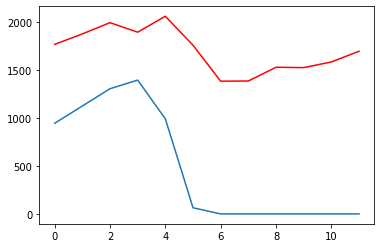

Coefficients: [ 7.62469009e+02  1.95769417e-01  3.65366797e-02  1.49372144e-01
 -4.22791607e-02  9.22073699e-02  2.28110255e-01  4.63797983e-03
 -4.25576104e-02 -5.40020894e-02  5.72117136e-02  2.94943735e-02
 -1.79504872e-02  2.18384832e-02 -6.42761870e-02 -1.65748047e-02
  2.00888468e-03 -2.76871344e-02 -3.45068719e-02  1.79420015e-02
 -7.45594987e-02]
predicted=1059.414329, expected=1000.000000
predicted=1005.293352, expected=900.000000
predicted=1224.295458, expected=0.000000
predicted=1387.553574, expected=1200.000000
predicted=1271.273351, expected=1200.000000
predicted=1226.990180, expected=600.000000
predicted=1279.092005, expected=200.000000
predicted=1326.123702, expected=300.000000
predicted=1354.388743, expected=1200.000000
predicted=1525.858729, expected=1200.000000
predicted=1461.553610, expected=600.000000
predicted=1359.133149, expected=200.000000
Test RMSE: 729.163
Test WMAPE: [960.13537427]


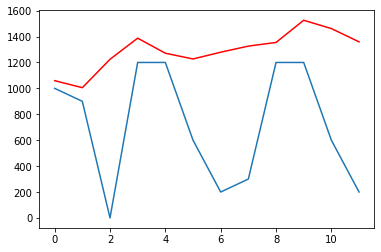

Coefficients: [ 7.67991927e+02  1.81474864e-01  4.10912511e-02  1.50346258e-01
 -3.77538738e-02  8.98021888e-02  2.31026508e-01  6.99341132e-03
 -4.19112300e-02 -6.16396491e-02  6.24567110e-02  2.97312963e-02
 -2.27257805e-02  3.11464915e-02 -6.26011422e-02 -2.16328732e-02
  5.69997881e-04 -2.91083566e-02 -3.11546893e-02  1.17457327e-02
 -7.10896529e-02]
predicted=1057.170114, expected=1000.000000
predicted=1009.426856, expected=900.000000
predicted=1212.726728, expected=0.000000
predicted=1385.207067, expected=1200.000000
predicted=1278.504204, expected=1200.000000
predicted=1224.802661, expected=600.000000
predicted=1278.360689, expected=200.000000
predicted=1326.744731, expected=300.000000
predicted=1346.137066, expected=1200.000000
predicted=1521.242118, expected=1200.000000
predicted=1466.547454, expected=600.000000
predicted=1358.693600, expected=200.000000
Test RMSE: 727.546
Test WMAPE: [957.98557518]


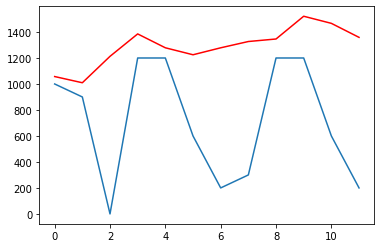

Coefficients: [ 9.11898372e+01  3.38452966e-01  2.49935349e-01  3.52908546e-01
 -1.91337801e-01 -2.44145753e-02 -3.93360651e-02  3.34111613e-01
  8.48752817e-03 -1.51681495e-01 -1.26483246e-01  3.01984897e-02
  1.43879563e-01 -7.41118814e-02 -1.86574203e-02  3.79858686e-02
  2.05318948e-01 -8.30431894e-03 -1.83056134e-01 -6.76679015e-02
  1.36568364e-01]
predicted=1156.957054, expected=2104.000000
predicted=1056.345027, expected=2000.000000
predicted=943.925094, expected=2200.000000
predicted=1902.525695, expected=2300.000000
predicted=1805.985202, expected=2911.000000
predicted=1321.276499, expected=3200.000000
predicted=1641.502760, expected=401.000000
predicted=1513.108254, expected=902.000000
predicted=1395.845387, expected=2610.000000
predicted=1296.196533, expected=1901.000000
predicted=1552.968606, expected=3400.000000
predicted=1784.526794, expected=2803.000000
Test RMSE: 1171.709
Test WMAPE: [420.2081593]


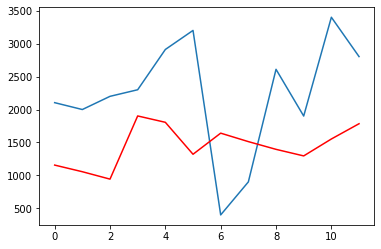

Coefficients: [ 2.30088457e+02  1.52426692e-01  1.74589744e-01 -1.03473993e-01
  2.29671754e-01  5.36091846e-02 -1.91644528e-01  1.05336070e-02
 -8.38957221e-03  1.04027566e-01  8.27231449e-02  1.60039253e-01
  7.88760404e-03  3.68511514e-02 -4.58485558e-02  6.38842768e-02
 -1.32881523e-03  9.04109599e-02  6.21415903e-02 -2.92157504e-02
 -1.03544901e-01]
predicted=465.125225, expected=1200.000000
predicted=625.282585, expected=1120.000000
predicted=792.525090, expected=960.000000
predicted=485.051555, expected=960.000000
predicted=501.600833, expected=840.000000
predicted=583.290128, expected=240.000000
predicted=785.036639, expected=0.000000
predicted=736.591602, expected=240.000000
predicted=631.974718, expected=1560.000000
predicted=470.586059, expected=1200.000000
predicted=613.000965, expected=1500.000000
predicted=698.768179, expected=640.000000
Test RMSE: 599.802
Test WMAPE: [352.33266789]


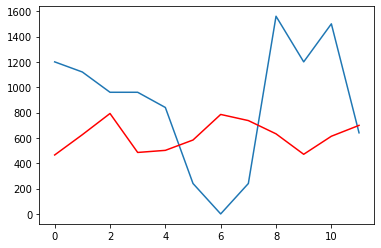

Coefficients: [ 2.30088457e+02  1.52426692e-01  1.74589744e-01 -1.03473993e-01
  2.29671754e-01  5.36091846e-02 -1.91644528e-01  1.05336070e-02
 -8.38957221e-03  1.04027566e-01  8.27231449e-02  1.60039253e-01
  7.88760404e-03  3.68511514e-02 -4.58485558e-02  6.38842768e-02
 -1.32881523e-03  9.04109599e-02  6.21415903e-02 -2.92157504e-02
 -1.03544901e-01]
predicted=465.125225, expected=1200.000000
predicted=625.282585, expected=1120.000000
predicted=792.525090, expected=960.000000
predicted=485.051555, expected=960.000000
predicted=501.600833, expected=840.000000
predicted=583.290128, expected=240.000000
predicted=785.036639, expected=0.000000
predicted=736.591602, expected=240.000000
predicted=631.974718, expected=1560.000000
predicted=470.586059, expected=1200.000000
predicted=613.000965, expected=1500.000000
predicted=698.768179, expected=640.000000
Test RMSE: 599.802
Test WMAPE: [352.33266789]


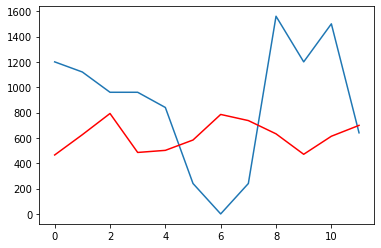

Coefficients: [ 3.72592401e+02  5.85213232e-01 -2.92049468e-03  1.47121824e-01
 -1.65684409e-01  1.00838778e-01 -5.82119209e-04 -5.82027526e-02
 -1.80570009e-02  1.31237740e-01 -5.02222555e-02  5.03540214e-02
 -1.24632153e-01  1.89075530e-01 -1.29079105e-01  3.01052783e-02
 -2.05597254e-01 -5.97391039e-02  1.12421678e-01  2.59614887e-03
  7.28715553e-02]
predicted=219.864116, expected=0.000000
predicted=430.586916, expected=0.000000
predicted=504.844694, expected=0.000000
predicted=684.816110, expected=0.000000
predicted=908.882283, expected=0.000000
predicted=1115.131252, expected=0.000000
predicted=955.326211, expected=0.000000
predicted=552.087311, expected=0.000000
predicted=564.186509, expected=0.000000
predicted=589.467592, expected=0.000000
predicted=710.930588, expected=0.000000
predicted=961.839555, expected=0.000000
Test RMSE: 726.920
Test WMAPE: [inf]


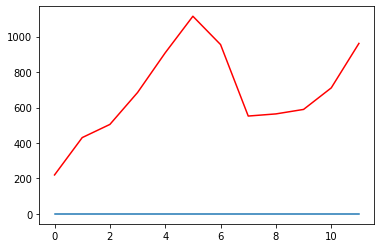

Coefficients: [ 3.74138078e+02  5.77964012e-01  3.99238154e-03  1.53203292e-01
 -1.76242769e-01  1.15960897e-01 -2.70211530e-02 -3.90538402e-02
 -2.42425118e-02  1.38615811e-01 -5.95399251e-02  5.24822061e-02
 -1.21231177e-01  1.85462539e-01 -1.27759385e-01  3.65076320e-02
 -2.09763635e-01 -6.36936338e-02  1.08599012e-01  1.94339511e-02
  6.17411634e-02]
predicted=229.000897, expected=0.000000
predicted=432.941848, expected=0.000000
predicted=484.303906, expected=0.000000
predicted=689.167724, expected=0.000000
predicted=908.571462, expected=0.000000
predicted=1128.508950, expected=0.000000
predicted=962.437508, expected=0.000000
predicted=548.038119, expected=0.000000
predicted=561.776921, expected=0.000000
predicted=599.860459, expected=0.000000
predicted=712.322136, expected=0.000000
predicted=959.459551, expected=0.000000
Test RMSE: 729.066
Test WMAPE: [inf]


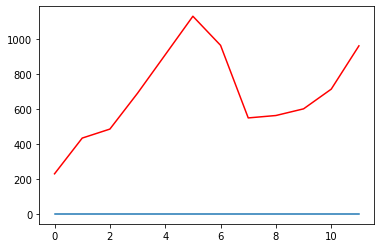

Coefficients: [-8.04078546e+00  4.42907187e-01  6.05810963e-02  2.05298896e-01
  2.19161536e-02 -1.42689633e-02  1.61470783e-01 -2.09975970e-02
  6.27795356e-02 -4.91910751e-03 -1.83205545e-01  2.97963077e-02
  2.18990418e-01 -3.45893630e-02 -1.69622318e-02  3.86915591e-02
  3.40713144e-02  4.38643132e-03 -9.18624071e-02  1.09305865e-01
 -6.40435784e-02]
predicted=-8.040785, expected=0.000000
predicted=-11.602107, expected=0.000000
predicted=-13.666562, expected=0.000000
predicted=-16.447437, expected=0.000000
predicted=-18.711532, expected=0.000000
predicted=-20.269931, expected=0.000000
predicted=-22.961010, expected=0.000000
predicted=-25.149834, expected=0.000000
predicted=-27.375553, expected=0.000000
predicted=-29.637971, expected=0.000000
predicted=-30.207117, expected=0.000000
predicted=-31.018419, expected=0.000000
Test RMSE: 22.509
Test WMAPE: [inf]


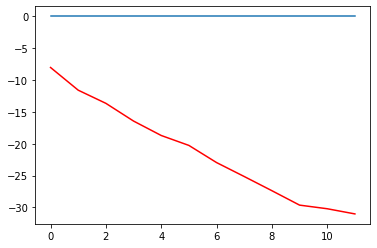

Coefficients: [-7.16213532e+00  4.38548738e-01  7.28451821e-02  1.97657012e-01
  4.06440778e-02 -1.47452864e-02  1.45136231e-01 -2.31611307e-03
  4.47078225e-02  1.09237723e-02 -1.83863150e-01  1.83836664e-02
  2.21464203e-01 -3.00324911e-02 -2.60217284e-02  3.93795305e-02
  2.34897308e-02  9.16979872e-03 -8.44086897e-02  9.75559759e-02
 -5.85292413e-02]
predicted=-7.162135, expected=0.000000
predicted=-10.303081, expected=0.000000
predicted=-12.202265, expected=0.000000
predicted=-14.679599, expected=0.000000
predicted=-16.816306, expected=0.000000
predicted=-18.331258, expected=0.000000
predicted=-20.711311, expected=0.000000
predicted=-22.799734, expected=0.000000
predicted=-24.827310, expected=0.000000
predicted=-26.942949, expected=0.000000
predicted=-27.612390, expected=0.000000
predicted=-28.411228, expected=0.000000
Test RMSE: 20.415
Test WMAPE: [inf]


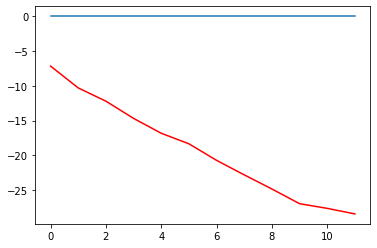

Coefficients: [ 3.02106764  0.35337981  0.16793742  0.12724173 -0.14925242  0.09429734
  0.04995277  0.01665715  0.03673739  0.16456377 -0.15566604  0.0704322
 -0.06152247  0.21074654 -0.04126142  0.04669678 -0.12787053  0.05816014
  0.14900397 -0.00617416 -0.06511577]
predicted=196.557709, expected=0.000000
predicted=52.839594, expected=120.000000
predicted=206.488731, expected=240.000000
predicted=189.292955, expected=0.000000
predicted=84.756806, expected=0.000000
predicted=109.318139, expected=0.000000
predicted=286.639866, expected=240.000000
predicted=125.430148, expected=480.000000
predicted=161.740257, expected=120.000000
predicted=73.491632, expected=0.000000
predicted=116.087032, expected=0.000000
predicted=219.454038, expected=480.000000
Test RMSE: 162.181
Test WMAPE: [101.49779033]


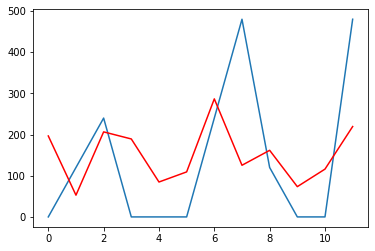

Coefficients: [-8.03215790e+00 -2.47426833e-02  1.83580253e-02  2.34088654e-01
  1.81389375e-01  1.23105371e-01  1.12569325e-02  1.23228981e-02
 -2.60500539e-02  1.04392856e-01  6.72946834e-02  5.86205848e-02
 -6.12807408e-02 -4.42075461e-02 -3.33273569e-02  1.80645255e-01
  9.80458769e-02 -5.21850672e-02  4.69443102e-02  6.92242929e-02
  7.29386912e-03]
predicted=61.915735, expected=0.000000
predicted=-2.548713, expected=150.000000
predicted=28.741530, expected=0.000000
predicted=101.576448, expected=240.000000
predicted=51.617111, expected=0.000000
predicted=20.361186, expected=360.000000
predicted=24.569836, expected=0.000000
predicted=14.452832, expected=0.000000
predicted=74.769580, expected=240.000000
predicted=94.019546, expected=240.000000
predicted=12.592281, expected=0.000000
predicted=24.333334, expected=240.000000
Test RMSE: 147.537
Test WMAPE: [786.61166885]


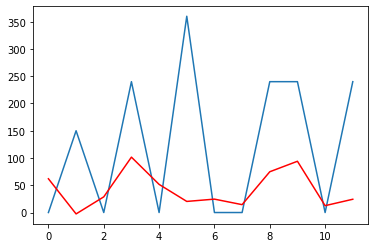

Coefficients: [-8.05609770e+00 -2.47569665e-02  1.83437762e-02  2.34063129e-01
  1.81384740e-01  1.23110409e-01  1.12785940e-02  1.23193612e-02
 -2.60406968e-02  1.04423027e-01  6.72684526e-02  5.86380098e-02
 -6.12733548e-02 -4.42047857e-02 -3.33307901e-02  1.80617700e-01
  9.80649261e-02 -5.21725647e-02  4.69437562e-02  6.92311052e-02
  7.31255197e-03]
predicted=61.904745, expected=0.000000
predicted=-2.550265, expected=150.000000
predicted=28.731847, expected=0.000000
predicted=101.546662, expected=240.000000
predicted=51.597449, expected=0.000000
predicted=20.334607, expected=360.000000
predicted=24.540401, expected=0.000000
predicted=14.418660, expected=0.000000
predicted=74.728453, expected=240.000000
predicted=93.983666, expected=240.000000
predicted=12.558280, expected=0.000000
predicted=24.290913, expected=240.000000
Test RMSE: 147.554
Test WMAPE: [786.86904695]


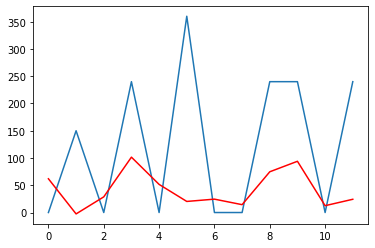

Coefficients: [-1.16284361e+01  3.30288801e-01  1.37059834e-01  1.66313294e-01
  1.11919586e-01  2.23205786e-02 -4.44471492e-03  3.19335509e-02
  1.01795802e-01 -2.05004015e-02  8.17830908e-02  9.91571032e-02
 -1.25915994e-01  3.40300745e-02 -2.35820361e-02  2.00854049e-03
  3.42714508e-02 -4.83841853e-02 -1.72355880e-02  7.01382782e-02
  6.14787904e-03]
predicted=-11.628436, expected=0.000000
predicted=-15.469178, expected=0.000000
predicted=-18.331524, expected=0.000000
predicted=-21.737300, expected=0.000000
predicted=-25.194718, expected=0.000000
predicted=-27.968914, expected=0.000000
predicted=-30.279893, expected=0.000000
predicted=-32.797758, expected=0.000000
predicted=-36.164132, expected=0.000000
predicted=-38.621962, expected=0.000000
predicted=-41.891509, expected=0.000000
predicted=-46.054769, expected=0.000000
Test RMSE: 30.643
Test WMAPE: [inf]


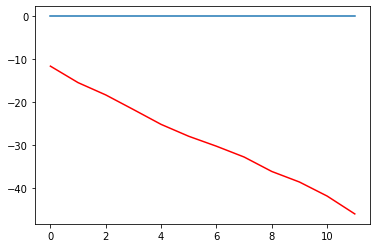

Coefficients: [ 1.0245336   0.36064586  0.16192565  0.12611217  0.10186466  0.02348202
 -0.03506774  0.07998132  0.06726924 -0.02096727  0.01263118  0.19944328
 -0.14420448  0.03502899  0.02075169 -0.0180246  -0.01053325 -0.05685613
  0.02336533  0.11480651 -0.0691866 ]
predicted=1.024534, expected=0.000000
predicted=1.394027, expected=0.000000
predicted=1.693182, expected=0.000000
predicted=1.990108, expected=0.000000
predicted=2.296595, expected=0.000000
predicted=2.554632, expected=0.000000
predicted=2.737987, expected=0.000000
predicted=2.990805, expected=0.000000
predicted=3.270389, expected=0.000000
predicted=3.485651, expected=0.000000
predicted=3.703494, expected=0.000000
predicted=4.120402, expected=0.000000
Test RMSE: 2.763
Test WMAPE: [inf]


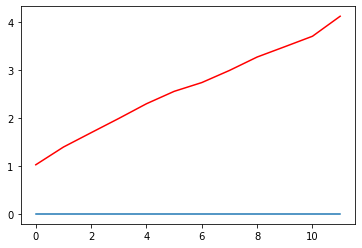

Coefficients: [ 3.64684006e+01  2.13951702e-01  2.36178302e-01  3.02301983e-01
  2.59000344e-03  5.36371106e-02 -2.38999336e-02 -5.57624063e-02
  1.04728077e-01  7.70304364e-02  1.14062192e-01 -1.50778400e-01
 -5.61030980e-02  5.87929255e-03  1.78219027e-01 -1.34754762e-02
 -7.13288231e-05 -1.34444634e-01  7.94107465e-02 -1.81430303e-02
 -1.25341477e-02]
predicted=36.468401, expected=0.000000
predicted=44.270877, expected=0.000000
predicted=54.553275, expected=0.000000
predicted=69.620457, expected=0.000000
predicted=77.725743, expected=0.000000
predicted=88.103081, expected=0.000000
predicted=96.366004, expected=0.000000
predicted=101.405514, expected=0.000000
predicted=111.539923, expected=0.000000
predicted=120.550779, expected=0.000000
predicted=131.777312, expected=0.000000
predicted=136.888667, expected=0.000000
Test RMSE: 94.676
Test WMAPE: [inf]


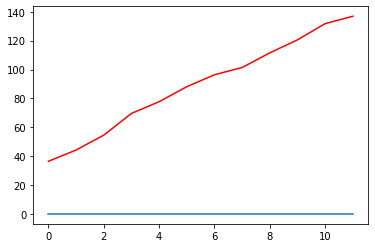

Coefficients: [ 3.64684006e+01  2.13951702e-01  2.36178302e-01  3.02301983e-01
  2.59000344e-03  5.36371106e-02 -2.38999336e-02 -5.57624063e-02
  1.04728077e-01  7.70304364e-02  1.14062192e-01 -1.50778400e-01
 -5.61030980e-02  5.87929255e-03  1.78219027e-01 -1.34754762e-02
 -7.13288231e-05 -1.34444634e-01  7.94107465e-02 -1.81430303e-02
 -1.25341477e-02]
predicted=36.468401, expected=0.000000
predicted=44.270877, expected=0.000000
predicted=54.553275, expected=0.000000
predicted=69.620457, expected=0.000000
predicted=77.725743, expected=0.000000
predicted=88.103081, expected=0.000000
predicted=96.366004, expected=0.000000
predicted=101.405514, expected=0.000000
predicted=111.539923, expected=0.000000
predicted=120.550779, expected=0.000000
predicted=131.777312, expected=0.000000
predicted=136.888667, expected=0.000000
Test RMSE: 94.676
Test WMAPE: [inf]


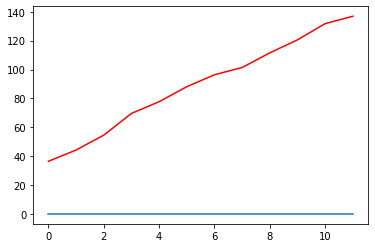

Coefficients: [ 1.17412270e+02 -3.81566578e-02  1.27856920e-01  1.31040218e-02
  2.06507717e-01  1.34408403e-01  6.35005379e-02  1.69440358e-01
 -6.70839724e-02  8.70922059e-02  3.89180418e-02  3.24869203e-02
 -5.63324372e-02 -4.58202297e-02  3.14524061e-02  9.60755300e-02
 -6.10738975e-02  2.29305004e-02  1.75612963e-02 -5.08381406e-02
  7.13532420e-02]
predicted=631.526494, expected=960.000000
predicted=468.457058, expected=880.000000
predicted=348.522964, expected=960.000000
predicted=739.824136, expected=1200.000000
predicted=604.807374, expected=1680.000000
predicted=668.235662, expected=600.000000
predicted=547.933430, expected=0.000000
predicted=567.064667, expected=0.000000
predicted=527.124757, expected=720.000000
predicted=693.546188, expected=720.000000
predicted=524.108875, expected=1920.000000
predicted=573.032645, expected=2060.000000
Test RMSE: 755.144
Test WMAPE: [492.90417957]


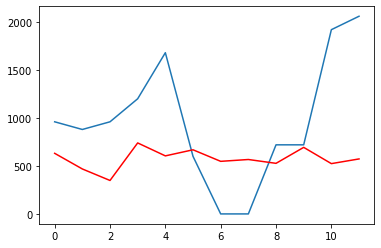

Coefficients: [ 1.17412270e+02 -3.81566578e-02  1.27856920e-01  1.31040218e-02
  2.06507717e-01  1.34408403e-01  6.35005379e-02  1.69440358e-01
 -6.70839724e-02  8.70922059e-02  3.89180418e-02  3.24869203e-02
 -5.63324372e-02 -4.58202297e-02  3.14524061e-02  9.60755300e-02
 -6.10738975e-02  2.29305004e-02  1.75612963e-02 -5.08381406e-02
  7.13532420e-02]
predicted=631.526494, expected=960.000000
predicted=468.457058, expected=880.000000
predicted=348.522964, expected=960.000000
predicted=739.824136, expected=1200.000000
predicted=604.807374, expected=1680.000000
predicted=668.235662, expected=600.000000
predicted=547.933430, expected=0.000000
predicted=567.064667, expected=0.000000
predicted=527.124757, expected=720.000000
predicted=693.546188, expected=720.000000
predicted=524.108875, expected=1920.000000
predicted=573.032645, expected=2060.000000
Test RMSE: 755.144
Test WMAPE: [492.90417957]


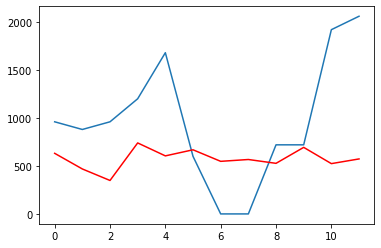

Coefficients: [ 4.57224749e+01  3.46467315e-01 -8.94194809e-02  2.88117001e-01
  3.54958547e-02  1.07118172e-01 -1.39935809e-01 -8.81325171e-02
  1.89687606e-02 -2.46127374e-02 -3.89503404e-02  2.40664187e-01
 -3.83225605e-02  1.35929350e-01 -1.40280447e-01 -7.96811621e-02
 -4.14541926e-02  1.48823476e-01  1.57232225e-01 -7.52068949e-02
  1.36343919e-01]
predicted=329.471259, expected=325.000000
predicted=182.501603, expected=162.000000
predicted=250.360513, expected=162.000000
predicted=247.726295, expected=324.000000
predicted=303.896736, expected=324.000000
predicted=224.644267, expected=324.000000
predicted=223.115755, expected=0.000000
predicted=269.668109, expected=0.000000
predicted=249.424144, expected=162.000000
predicted=259.900350, expected=162.000000
predicted=252.092778, expected=162.000000
predicted=285.442956, expected=324.000000
Test RMSE: 120.303
Test WMAPE: [319.49556459]


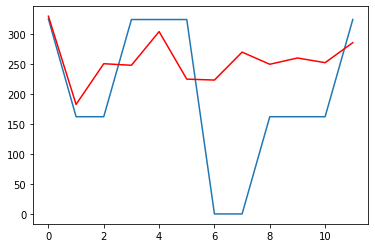

Coefficients: [ 4.47532023e+01  3.56451887e-01 -1.07959242e-01  3.03832011e-01
  2.98292152e-02  1.01156549e-01 -1.35698900e-01 -7.93210265e-02
  1.83058069e-03 -1.31143702e-02 -4.61118969e-02  2.43326699e-01
 -3.51002169e-02  1.39236840e-01 -1.51340916e-01 -7.76699168e-02
 -3.13254459e-02  1.40478212e-01  1.56581175e-01 -7.56378939e-02
  1.41811037e-01]
predicted=332.948922, expected=325.000000
predicted=177.496161, expected=162.000000
predicted=250.486801, expected=162.000000
predicted=250.160462, expected=324.000000
predicted=301.036817, expected=324.000000
predicted=222.452758, expected=324.000000
predicted=222.999397, expected=0.000000
predicted=270.580955, expected=0.000000
predicted=244.732771, expected=162.000000
predicted=261.337240, expected=162.000000
predicted=250.955077, expected=162.000000
predicted=284.279691, expected=324.000000
Test RMSE: 120.267
Test WMAPE: [315.16267437]


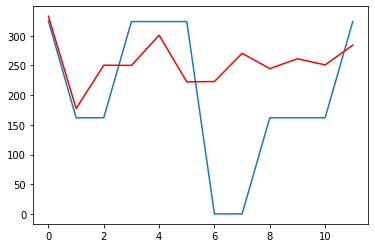

Coefficients: [ 1.08849238e+01  2.57165467e-01  1.61470987e-01  7.44972092e-02
 -9.14041750e-02  2.03717045e-01  8.42033184e-02  3.68276669e-02
  7.42554236e-02  5.97506347e-02  9.51361522e-02 -1.16751857e-01
 -2.73083375e-03 -5.88871701e-02 -8.54527619e-02 -1.00397922e-02
  1.01025219e-01 -4.16171667e-02 -1.22056094e-01  1.09721095e-01
  3.86652283e-03]
predicted=112.119646, expected=290.000000
predicted=113.860127, expected=16.000000
predicted=95.404872, expected=154.000000
predicted=75.445476, expected=160.000000
predicted=75.228898, expected=152.000000
predicted=74.288711, expected=118.000000
predicted=76.904746, expected=90.000000
predicted=66.491417, expected=52.000000
predicted=95.107401, expected=130.000000
predicted=86.472798, expected=80.000000
predicted=51.034188, expected=90.000000
predicted=61.342588, expected=190.000000
Test RMSE: 81.301
Test WMAPE: [424.41455837]


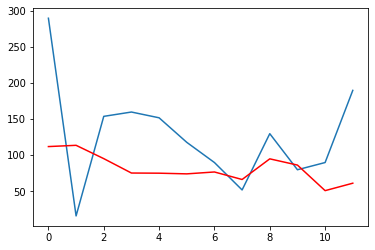

Coefficients: [ 1.08849238e+01  2.57165467e-01  1.61470987e-01  7.44972092e-02
 -9.14041750e-02  2.03717045e-01  8.42033184e-02  3.68276669e-02
  7.42554236e-02  5.97506347e-02  9.51361522e-02 -1.16751857e-01
 -2.73083375e-03 -5.88871701e-02 -8.54527619e-02 -1.00397922e-02
  1.01025219e-01 -4.16171667e-02 -1.22056094e-01  1.09721095e-01
  3.86652283e-03]
predicted=112.119646, expected=290.000000
predicted=113.860127, expected=16.000000
predicted=95.404872, expected=154.000000
predicted=75.445476, expected=160.000000
predicted=75.228898, expected=152.000000
predicted=74.288711, expected=118.000000
predicted=76.904746, expected=90.000000
predicted=66.491417, expected=52.000000
predicted=95.107401, expected=130.000000
predicted=86.472798, expected=80.000000
predicted=51.034188, expected=90.000000
predicted=61.342588, expected=190.000000
Test RMSE: 81.301
Test WMAPE: [424.41455837]


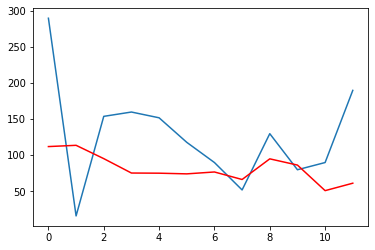

Coefficients: [ 1.04350839e+02  8.09780995e-02  1.22165117e-01  7.03066270e-03
  7.03794799e-02  9.71154612e-02  1.92747934e-01 -9.17767360e-02
 -5.73563365e-02  1.84724517e-02  1.00995192e-02 -9.82128780e-03
 -3.62536504e-02 -1.52489512e-02  1.07931414e-01  1.06650723e-01
 -1.67245607e-01 -4.82010918e-02  3.95885574e-02  5.05472081e-02
  2.84352896e-02]
predicted=171.595720, expected=120.000000
predicted=202.992680, expected=120.000000
predicted=234.577367, expected=230.000000
predicted=210.681266, expected=190.000000
predicted=176.781911, expected=230.000000
predicted=184.731975, expected=140.000000
predicted=236.161497, expected=40.000000
predicted=220.467183, expected=140.000000
predicted=192.864515, expected=270.000000
predicted=187.781144, expected=218.000000
predicted=219.233951, expected=200.000000
predicted=249.794306, expected=240.000000
Test RMSE: 74.786
Test WMAPE: [196.25641647]


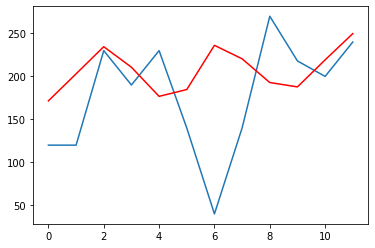

Coefficients: [ 1.04404521e+02  8.03511404e-02  1.21340810e-01  8.34775947e-03
  7.33383446e-02  9.69764104e-02  1.91875737e-01 -9.00630939e-02
 -5.76696158e-02  1.71009139e-02  7.77168090e-03 -8.58266038e-03
 -3.67866314e-02 -1.65665417e-02  1.07980304e-01  1.06594154e-01
 -1.65148478e-01 -4.79163785e-02  3.85074608e-02  4.87312233e-02
  2.86656684e-02]
predicted=170.221443, expected=120.000000
predicted=200.074804, expected=120.000000
predicted=231.650769, expected=230.000000
predicted=206.864801, expected=190.000000
predicted=178.855140, expected=230.000000
predicted=181.368951, expected=140.000000
predicted=230.427329, expected=40.000000
predicted=224.582237, expected=140.000000
predicted=194.003529, expected=270.000000
predicted=187.092439, expected=218.000000
predicted=217.466262, expected=200.000000
predicted=244.520898, expected=240.000000
Test RMSE: 73.042
Test WMAPE: [184.73074128]


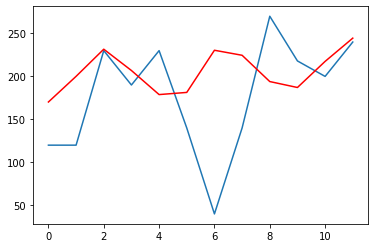

Coefficients: [ 1.26212155e+02  4.07408081e-01  4.63901094e-03 -1.22447526e-01
  1.49265359e-01 -2.00421926e-02 -5.11665389e-03  1.31620074e-01
 -8.78835898e-02 -5.89663736e-02 -1.24486695e-01  6.93152796e-02
 -1.57244553e-01  1.26093165e-01  6.87356380e-02 -2.04037860e-01
  5.25037032e-02 -6.29221989e-02 -1.77773880e-02  1.03580576e-01
 -5.50548158e-02]
predicted=177.352579, expected=495.000000
predicted=138.576583, expected=585.000000
predicted=149.289443, expected=135.000000
predicted=222.233770, expected=90.000000
predicted=151.236556, expected=315.000000
predicted=157.792451, expected=135.000000
predicted=118.546949, expected=0.000000
predicted=165.561129, expected=45.000000
predicted=199.679299, expected=180.000000
predicted=191.282172, expected=90.000000
predicted=206.244368, expected=135.000000
predicted=166.668581, expected=270.000000
Test RMSE: 182.622
Test WMAPE: [208.74478548]


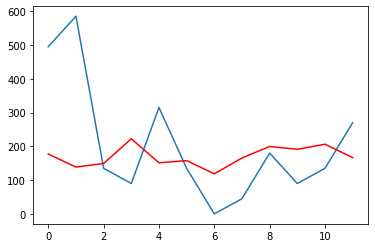

Coefficients: [ 1.26212155e+02  4.07408081e-01  4.63901094e-03 -1.22447526e-01
  1.49265359e-01 -2.00421926e-02 -5.11665389e-03  1.31620074e-01
 -8.78835898e-02 -5.89663736e-02 -1.24486695e-01  6.93152796e-02
 -1.57244553e-01  1.26093165e-01  6.87356380e-02 -2.04037860e-01
  5.25037032e-02 -6.29221989e-02 -1.77773880e-02  1.03580576e-01
 -5.50548158e-02]
predicted=177.352579, expected=495.000000
predicted=138.576583, expected=585.000000
predicted=149.289443, expected=135.000000
predicted=222.233770, expected=90.000000
predicted=151.236556, expected=315.000000
predicted=157.792451, expected=135.000000
predicted=118.546949, expected=0.000000
predicted=165.561129, expected=45.000000
predicted=199.679299, expected=180.000000
predicted=191.282172, expected=90.000000
predicted=206.244368, expected=135.000000
predicted=166.668581, expected=270.000000
Test RMSE: 182.622
Test WMAPE: [208.74478548]


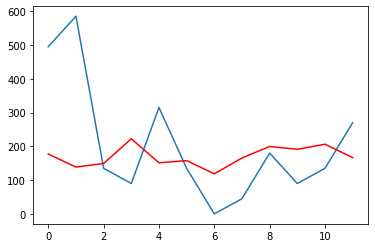

Coefficients: [ 4.14411250e+01  4.12290973e-01  3.97164133e-02  2.27388793e-01
 -3.87582357e-02  5.77312375e-02 -1.58684153e-02  4.02179762e-03
  3.53466048e-02 -7.92962909e-02 -4.08710877e-02  9.19368612e-02
 -2.98816032e-02  5.13371482e-02 -1.13171703e-01  1.31985765e-02
 -9.00956225e-03  1.84596310e-01 -8.00665279e-02  3.36063071e-02
 -1.07595887e-02]
predicted=41.441125, expected=0.000000
predicted=58.526927, expected=0.000000
predicted=67.217141, expected=0.000000
predicted=80.901873, expected=0.000000
predicted=89.168043, expected=0.000000
predicted=96.825908, expected=0.000000
predicted=103.415196, expected=0.000000
predicted=108.182521, expected=0.000000
predicted=114.016335, expected=0.000000
predicted=115.425239, expected=0.000000
predicted=114.691012, expected=0.000000
predicted=118.784417, expected=0.000000
Test RMSE: 95.532
Test WMAPE: [inf]


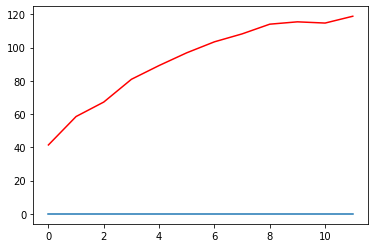

Coefficients: [ 4.31987928e+01  4.11785820e-01  5.07781230e-02  1.96812761e-01
  3.73142776e-03  4.40099030e-02 -2.48423297e-02  6.03457689e-03
  1.72538097e-02 -5.27715118e-02 -5.72992823e-02  1.04257276e-01
 -2.29604992e-02  1.35543628e-02 -6.73472187e-02 -1.23623508e-02
 -9.14509397e-03  1.79047346e-01 -6.86804240e-02  4.25276205e-02
 -3.03454359e-02]
predicted=43.198793, expected=0.000000
predicted=60.987443, expected=0.000000
predicted=70.506111, expected=0.000000
predicted=83.831111, expected=0.000000
predicted=93.463724, expected=0.000000
predicted=101.947863, expected=0.000000
predicted=108.298403, expected=0.000000
predicted=113.527507, expected=0.000000
predicted=118.911634, expected=0.000000
predicted=120.853394, expected=0.000000
predicted=119.943970, expected=0.000000
predicted=124.086212, expected=0.000000
Test RMSE: 99.942
Test WMAPE: [inf]


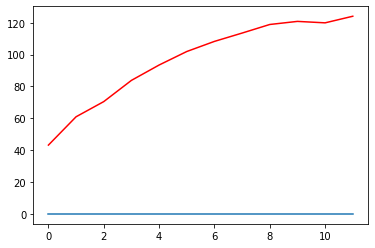

Coefficients: [ 9.27149915e+00  4.24252707e-01  1.90173805e-01  2.34022526e-01
  2.64787386e-02  1.14679647e-02 -9.64738591e-02  5.09806789e-02
  1.26675509e-01  3.80165737e-03 -6.32127468e-03 -7.06221646e-02
 -1.01574011e-02  6.82818597e-02  1.06555868e-01 -6.20806331e-03
 -1.83484925e-03 -1.15173487e-01 -5.04048935e-02  3.50504527e-02
  1.26864544e-02]
predicted=9.078551, expected=0.000000
predicted=13.225061, expected=0.000000
predicted=16.862121, expected=0.000000
predicted=21.072548, expected=0.000000
predicted=24.741027, expected=0.000000
predicted=28.034560, expected=0.000000
predicted=30.503778, expected=0.000000
predicted=33.409077, expected=0.000000
predicted=37.114510, expected=0.000000
predicted=40.059663, expected=0.000000
predicted=43.085472, expected=4.000000
predicted=45.424102, expected=0.000000
Test RMSE: 30.282
Test WMAPE: [101583.14069591]


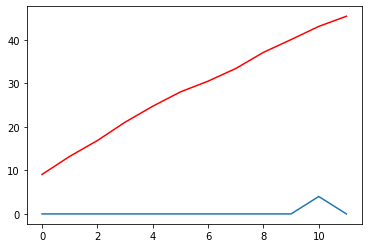

Coefficients: [ 1.65475851e+01  5.07893802e-02  8.60765414e-02  2.10084675e-01
  1.27640223e-01 -3.06927241e-02  4.98575988e-02 -8.12547979e-02
  1.39522181e-01  2.03404215e-01  2.32596829e-02 -8.69426931e-02
 -1.59973776e-02 -7.82998627e-02  1.46577996e-01 -3.68670852e-02
  2.43318191e-02  7.83403451e-02  1.84697295e-01 -7.47767799e-02
 -4.06559481e-02]
predicted=81.846399, expected=160.000000
predicted=137.020501, expected=80.000000
predicted=158.587616, expected=250.000000
predicted=134.400115, expected=140.000000
predicted=185.205157, expected=200.000000
predicted=183.732049, expected=0.000000
predicted=117.756838, expected=0.000000
predicted=182.385449, expected=160.000000
predicted=156.184511, expected=106.000000
predicted=92.083080, expected=250.000000
predicted=146.437136, expected=140.000000
predicted=164.609581, expected=200.000000
Test RMSE: 88.901
Test WMAPE: [38.61098493]


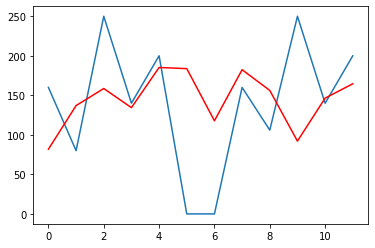

Coefficients: [ 1.65475851e+01  5.07893802e-02  8.60765414e-02  2.10084675e-01
  1.27640223e-01 -3.06927241e-02  4.98575988e-02 -8.12547979e-02
  1.39522181e-01  2.03404215e-01  2.32596829e-02 -8.69426931e-02
 -1.59973776e-02 -7.82998627e-02  1.46577996e-01 -3.68670852e-02
  2.43318191e-02  7.83403451e-02  1.84697295e-01 -7.47767799e-02
 -4.06559481e-02]
predicted=81.846399, expected=160.000000
predicted=137.020501, expected=80.000000
predicted=158.587616, expected=250.000000
predicted=134.400115, expected=140.000000
predicted=185.205157, expected=200.000000
predicted=183.732049, expected=0.000000
predicted=117.756838, expected=0.000000
predicted=182.385449, expected=160.000000
predicted=156.184511, expected=106.000000
predicted=92.083080, expected=250.000000
predicted=146.437136, expected=140.000000
predicted=164.609581, expected=200.000000
Test RMSE: 88.901
Test WMAPE: [38.61098493]


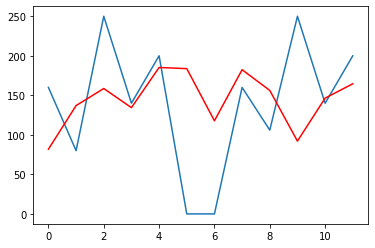

Coefficients: [ 1.13836249e+02  4.09940619e-01 -6.56330512e-02 -3.75914815e-02
 -3.39363261e-02 -1.04207628e-01 -6.45763075e-02 -2.05851436e-02
  1.14322959e-02 -8.83951433e-02 -5.67932104e-02 -1.96001441e-01
  1.08664537e-01 -3.16573379e-02 -2.69661806e-03  1.59148469e-02
 -1.96091021e-01  8.29083594e-02 -2.67783124e-01  6.47900314e-02
 -1.23158056e-03]
predicted=-10.690703, expected=0.000000
predicted=-72.405158, expected=0.000000
predicted=-24.147473, expected=0.000000
predicted=-0.167621, expected=0.000000
predicted=160.510526, expected=0.000000
predicted=151.313583, expected=0.000000
predicted=108.591961, expected=0.000000
predicted=86.533887, expected=0.000000
predicted=-58.623401, expected=0.000000
predicted=31.101806, expected=0.000000
predicted=-37.718005, expected=0.000000
predicted=106.801479, expected=0.000000
Test RMSE: 87.136
Test WMAPE: [inf]


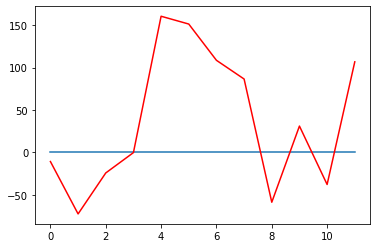

Coefficients: [ 1.13796119e+02  4.09897830e-01 -6.55385549e-02 -3.76822333e-02
 -3.39236157e-02 -1.04051764e-01 -6.45531969e-02 -2.06947316e-02
  1.16570761e-02 -8.86852483e-02 -5.65835436e-02 -1.95943675e-01
  1.08646063e-01 -3.17015511e-02 -2.57579977e-03  1.55836489e-02
 -1.95690158e-01  8.26169968e-02 -2.67475625e-01  6.47530785e-02
 -1.27358205e-03]
predicted=-10.574680, expected=0.000000
predicted=-72.457334, expected=0.000000
predicted=-24.054441, expected=0.000000
predicted=-0.136636, expected=0.000000
predicted=160.461636, expected=0.000000
predicted=151.159569, expected=0.000000
predicted=108.558234, expected=0.000000
predicted=86.338008, expected=0.000000
predicted=-58.490158, expected=0.000000
predicted=31.069277, expected=0.000000
predicted=-37.577550, expected=0.000000
predicted=106.791111, expected=0.000000
Test RMSE: 87.073
Test WMAPE: [inf]


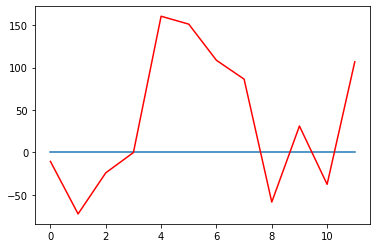

Coefficients: [ 3.75710278  0.10302546  0.06152719  0.18646066  0.0210044  -0.06453714
 -0.0108144  -0.06667352  0.10107694  0.1168865   0.03515394 -0.0504886
  0.00421308  0.0093816   0.100505    0.05280275 -0.05924893 -0.02304698
  0.05642497  0.21774698 -0.04703465]
predicted=9.847923, expected=0.000000
predicted=11.203448, expected=1.000000
predicted=14.518210, expected=6.000000
predicted=13.069655, expected=2.000000
predicted=11.235620, expected=11.000000
predicted=13.567777, expected=14.000000
predicted=16.276901, expected=4.000000
predicted=15.566515, expected=0.000000
predicted=10.989109, expected=12.000000
predicted=12.647575, expected=14.000000
predicted=13.877846, expected=10.000000
predicted=12.934301, expected=15.000000
Test RMSE: 8.224
Test WMAPE: [899.79611679]


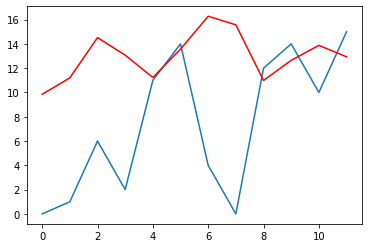

Coefficients: [ 5.60998201e+00  1.49280487e-01 -4.78763136e-02  4.51537432e-02
 -1.01443799e-01  9.94556752e-02  1.58607334e-01 -1.19906844e-02
  5.36094731e-02  1.85405717e-01  1.34555089e-01 -9.48789996e-02
  5.90921915e-03 -6.62114033e-02  3.38832421e-02  9.33928234e-02
 -1.24884595e-01  9.81713600e-02  1.16156098e-03  1.07093009e-01
 -8.09577120e-02]
predicted=12.076561, expected=9.000000
predicted=12.346957, expected=7.000000
predicted=14.485152, expected=12.000000
predicted=11.828403, expected=2.000000
predicted=10.433107, expected=13.000000
predicted=12.375249, expected=11.000000
predicted=13.300233, expected=5.000000
predicted=11.056427, expected=0.000000
predicted=12.596855, expected=11.000000
predicted=12.489921, expected=10.000000
predicted=14.007886, expected=9.000000
predicted=14.993376, expected=20.000000
Test RMSE: 5.769
Test WMAPE: [473.28579059]


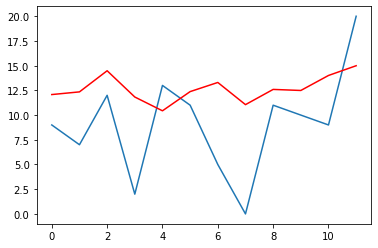

Coefficients: [ 4.17522348e+00  5.45167022e-02 -4.36520995e-02  7.04884900e-03
 -3.79396446e-02  1.34055319e-02 -3.29107347e-02  2.21719656e-03
 -8.79578710e-02  6.05938667e-02 -2.92479584e-02 -1.26736303e-01
  6.54945306e-02  6.34359630e-02 -2.19850666e-02 -3.21031873e-03
  5.39361573e-02  5.05779446e-03 -1.22035043e-01  1.43815167e-02
  8.32693920e-02]
predicted=4.110293, expected=3.000000
predicted=3.422287, expected=8.000000
predicted=4.131515, expected=4.000000
predicted=3.070519, expected=0.000000
predicted=3.740281, expected=7.000000
predicted=3.681767, expected=13.000000
predicted=4.667156, expected=2.000000
predicted=3.667088, expected=0.000000
predicted=3.258982, expected=3.000000
predicted=4.633727, expected=10.000000
predicted=3.545206, expected=12.000000
predicted=3.007289, expected=8.000000
Test RMSE: 4.786
Test WMAPE: [429.66668393]


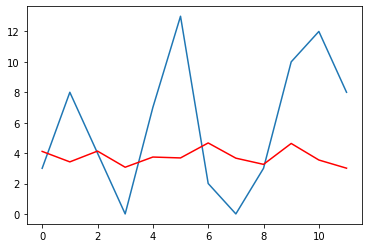

Coefficients: [ 1.65022883e+00  9.05513688e-01  2.06349136e-03 -1.01864074e-02
 -6.77722834e-02  2.71056389e-02  3.25682324e-02 -9.02640354e-03
 -7.14285430e-02  2.78741580e-02  2.88676103e-02 -1.39032973e-03
 -1.53353026e-02 -9.51152458e-02  9.66934046e-02 -6.78310561e-03
 -1.26449101e-02 -7.14617140e-02  4.24269962e-02  2.35226946e-02
 -7.82694229e-02]
predicted=8.882021, expected=9.000000
predicted=8.665594, expected=9.000000
predicted=8.262897, expected=10.000000
predicted=8.094099, expected=10.000000
predicted=7.998537, expected=10.000000
predicted=7.811952, expected=10.000000
predicted=7.424096, expected=11.000000
predicted=7.235011, expected=11.000000
predicted=7.109666, expected=11.000000
predicted=6.927783, expected=11.000000
predicted=6.716922, expected=11.000000
predicted=6.466033, expected=12.000000
Test RMSE: 3.204
Test WMAPE: [320.69173914]


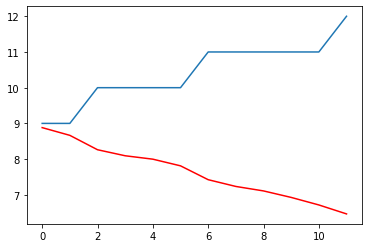

Coefficients: [ 6.83719204e+00  8.83356071e-01 -4.99558623e-03 -4.99558623e-03
 -4.99558623e-03 -4.99558623e-03 -4.99558623e-03 -4.99558623e-03
 -4.99558623e-03 -4.99558623e-03 -4.99558623e-03 -4.99558623e-03
 -4.99558623e-03 -4.99558623e-03 -4.99558623e-03 -4.99558623e-03
 -4.99558623e-03 -4.99558623e-03 -4.99558623e-03 -4.99558623e-03
 -5.32060027e-02]
predicted=36.090843, expected=38.000000
predicted=35.144608, expected=39.000000
predicted=34.175156, expected=40.000000
predicted=33.194918, expected=41.000000
predicted=32.214991, expected=42.000000
predicted=31.245230, expected=43.000000
predicted=30.294342, expected=44.000000
predicted=29.369964, expected=45.000000
predicted=28.478751, expected=46.000000
predicted=27.626447, expected=47.000000
predicted=26.817962, expected=48.000000
predicted=26.057437, expected=49.000000
Test RMSE: 14.250
Test WMAPE: [347.79161265]


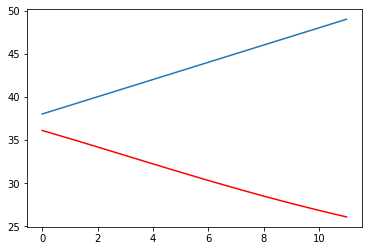

Coefficients: [ 1.09730794e+01  9.72547350e-01  2.96927458e-12 -1.46650973e-12
  5.49329078e-14  3.74330973e-13 -1.15612144e-12  1.15805855e-12
  1.36549444e-12 -1.33468274e-12 -9.57822481e-13 -1.21478598e-12
 -1.32946767e-12 -1.26588564e-12 -8.60507443e-13  1.43118397e-12
 -1.51769285e-12 -2.02367428e-12  2.90783642e-12  3.91479960e-13
  2.20259630e-02]
predicted=2019.016599, expected=2019.000000
predicted=2019.032743, expected=2019.000000
predicted=2019.048443, expected=2019.000000
predicted=2019.063713, expected=2019.000000
predicted=2019.078563, expected=2019.000000
predicted=2019.093005, expected=2019.000000
predicted=2019.107051, expected=2019.000000
predicted=2019.120712, expected=2019.000000
predicted=2019.133997, expected=2019.000000
predicted=2019.146918, expected=2019.000000
predicted=2019.159484, expected=2019.000000
predicted=2019.171705, expected=2019.000000
Test RMSE: 0.109
Test WMAPE: [0.05809474]


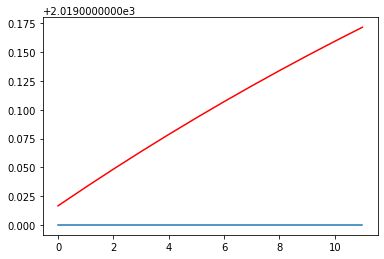

Coefficients: [ 0.04761107 -0.03671517 -0.03503902 -0.03465197  0.17582114 -0.0141738
 -0.02251559 -0.02267057 -0.06787406 -0.08410017 -0.0407373  -0.04059265
 -0.0339802   0.26959747 -0.02560082 -0.02645836 -0.02754202 -0.13635961
 -0.03990415 -0.03739828 -0.03719919]
predicted=0.047611, expected=0.000000
predicted=0.045863, expected=0.000000
predicted=0.044259, expected=0.000000
predicted=0.042729, expected=0.000000
predicted=0.051273, expected=0.000000
predicted=0.050087, expected=0.000000
predicted=0.048555, expected=1.000000
predicted=0.047070, expected=0.000000
predicted=0.045587, expected=0.000000
predicted=0.041603, expected=0.000000
predicted=0.039758, expected=0.000000
predicted=0.037988, expected=0.000000
Test RMSE: 0.278
Test WMAPE: [549.13999358]


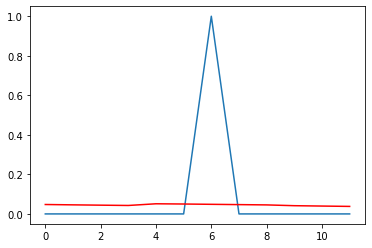

Coefficients: [ 0.05088063 -0.03816047 -0.03816047 -0.03913894 -0.03913894 -0.03913894
 -0.03913894 -0.03913894 -0.05088063 -0.05088063 -0.05088063 -0.05088063
 -0.05088063  0.28245271 -0.03816047 -0.03816047 -0.03522505 -0.03522505
 -0.03522505 -0.03522505 -0.03522505]
predicted=0.015656, expected=0.000000
predicted=0.015058, expected=0.000000
predicted=0.014484, expected=0.000000
predicted=0.013916, expected=0.000000
predicted=0.013370, expected=0.000000
predicted=0.048070, expected=0.000000
predicted=0.046222, expected=0.000000
predicted=0.044445, expected=0.000000
predicted=0.042519, expected=0.000000
predicted=0.040674, expected=0.000000
predicted=0.038908, expected=0.000000
predicted=0.037219, expected=0.000000
Test RMSE: 0.034
Test WMAPE: [inf]


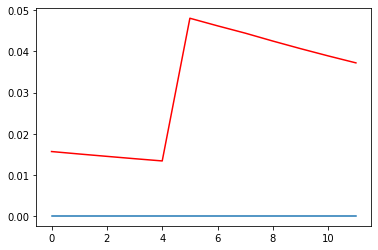

In [27]:
Wmape_array = []
for m in tdf3.columns[1:]:
    w_mape = autoregression(m)
    Wmape_array.append(w_mape)

In [28]:
import statistics as st

print('median',st.median(Wmape_array))
print('mean',st.mean(Wmape_array))

median 672.8477611029602
mean inf


## AutoARIMA

In [66]:
df_final = tdf3.T.reset_index()
df_final.columns = df_final.iloc[0]
df_final = df_final[1:].fillna(0)
df_final = df_final.rename(columns={'date': 'Parts'}).set_index('Parts')

In [67]:
df_final.head(1)

0         2016-01-01  2016-01-08  2016-01-15  2016-01-22  2016-01-29  \
Parts                                                                  
29032636       432.0      9316.0      8964.0      9000.0      6264.0   

0         2016-02-05  2016-02-12  2016-02-19  2016-02-26  2016-03-04  ...  \
Parts                                                                 ...   
29032636     10476.0      9180.0      8856.0      6228.0      9468.0  ...   

0         2019-10-04  2019-10-11  2019-10-18  2019-10-25  2019-11-01  \
Parts                                                                  
29032636      1512.0      1512.0      1260.0      1369.0       432.0   

0         2019-11-08  2019-11-15  2019-11-22  2019-11-29  2019-12-06  
Parts                                                                 
29032636       180.0      1404.0      1332.0       972.0      1512.0  

[1 rows x 206 columns]

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1785.500, BIC=1812.949, Time=0.450 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1800.423, BIC=1816.892, Time=0.175 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1789.964, BIC=1809.179, Time=0.080 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1788.927, BIC=1808.142, Time=0.112 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1799.393, BIC=1813.117, Time=0.138 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1783.819, BIC=1808.523, Time=0.201 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1788.181, BIC=1810.141, Time=0.214 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1790.136, BIC=1812.095, Time=0.135 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1785.480, BIC=1812.930, Time=0.545 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1783.558, BIC=1808.

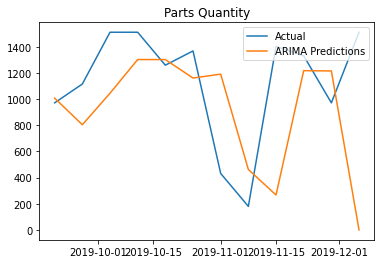

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1783.808, BIC=1811.257, Time=0.583 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1798.067, BIC=1814.537, Time=0.179 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1788.249, BIC=1807.464, Time=0.084 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1787.128, BIC=1806.342, Time=0.152 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1797.087, BIC=1810.811, Time=0.162 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1782.205, BIC=1806.909, Time=0.328 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1786.700, BIC=1808.659, Time=0.181 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1788.459, BIC=1810.419, Time=0.177 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1783.636, BIC=1811.086, Time=0.477 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1781.731, BIC=1806.

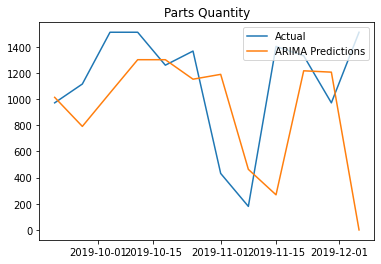

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1886.939, BIC=1911.565, Time=0.988 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1931.642, BIC=1945.323, Time=0.118 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1903.234, BIC=1919.652, Time=0.249 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1880.933, BIC=1897.350, Time=0.381 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.993)
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1931.976, BIC=1942.921, Time=0.100 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1885.279, BIC=1907.168, Time=0.494 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); A

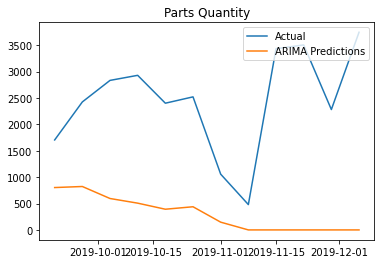

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1887.791, BIC=1912.417, Time=0.996 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1931.729, BIC=1945.410, Time=0.118 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1902.455, BIC=1918.873, Time=0.297 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1880.969, BIC=1897.387, Time=0.340 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.994)
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1932.061, BIC=1943.005, Time=0.089 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1886.302, BIC=1908.191, Time=0.898 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1883.005, BIC=1902.158, Time=0.650 seconds
Fit ARIMA: (0, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1885.229, BIC=1907.118, Time=0.712 seconds
Fit ARIMA: (1,

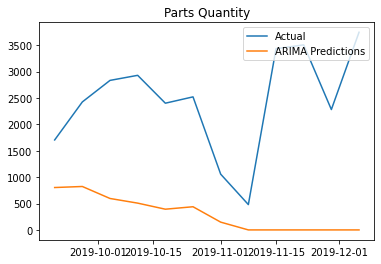

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1859.933, BIC=1887.382, Time=0.246 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1853.930, BIC=1870.399, Time=0.253 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1858.025, BIC=1877.239, Time=0.078 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1854.533, BIC=1873.747, Time=0.107 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1867.781, BIC=1881.506, Time=0.149 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1856.438, BIC=1878.398, Time=0.157 seconds
Total fit time: 1.002 seconds


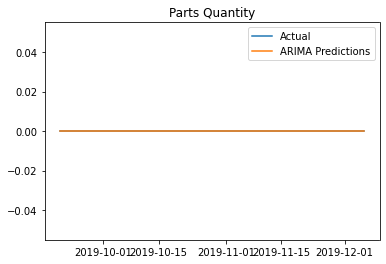

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1851.904, BIC=1879.354, Time=0.853 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1853.216, BIC=1869.686, Time=0.249 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1857.199, BIC=1876.414, Time=0.080 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1853.889, BIC=1873.103, Time=0.106 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1867.091, BIC=1880.815, Time=0.162 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1830.342, BIC=1855.046, Time=0.761 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1855.498, BIC=1877.458, Time=0.231 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1855.790, BIC=1877.749, Time=0.189 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1823.338, BIC=1850.788, Time=0.772 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1857.324, BIC=1882.

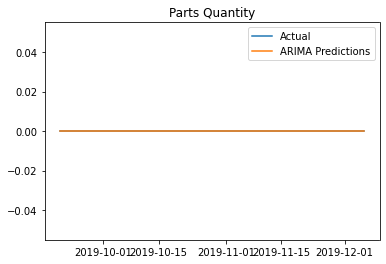

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1889.885, BIC=1917.334, Time=0.918 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1903.562, BIC=1920.031, Time=0.085 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1903.239, BIC=1922.454, Time=0.078 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1891.255, BIC=1910.469, Time=0.152 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1901.563, BIC=1915.287, Time=0.124 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1887.516, BIC=1912.221, Time=0.901 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1888.983, BIC=1910.943, Time=0.556 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1905.295, BIC=1927.254, Time=0.249 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1889.680, BIC=1917.130, Time=0.984 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1890.615, BIC=1915.

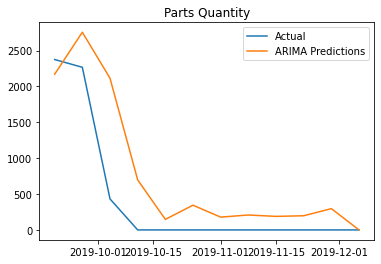

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1889.517, BIC=1916.966, Time=0.571 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1902.175, BIC=1918.644, Time=0.090 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1901.820, BIC=1921.034, Time=0.078 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1890.348, BIC=1909.562, Time=0.137 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1900.176, BIC=1913.900, Time=0.134 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1889.478, BIC=1914.182, Time=0.898 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1888.070, BIC=1910.029, Time=0.423 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1890.073, BIC=1914.778, Time=0.508 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1904.444, BIC=1926.403, Time=0.214 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1889.439, BIC=1916.

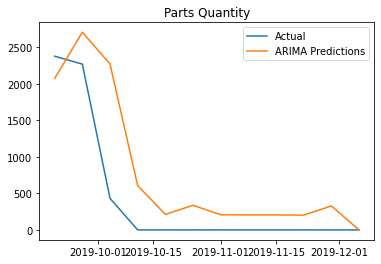

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1766.044, BIC=1790.748, Time=0.943 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1783.962, BIC=1797.687, Time=0.093 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1777.264, BIC=1793.734, Time=0.068 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1779.604, BIC=1796.073, Time=0.134 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1781.973, BIC=1792.952, Time=0.091 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1763.619, BIC=1785.579, Time=0.760 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1779.181, BIC=1798.396, Time=0.118 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1761.759, BIC=1780.974, Time=0.415 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1764.319, BIC=1786.279, Time=0.411 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1773.961, BIC=1793.

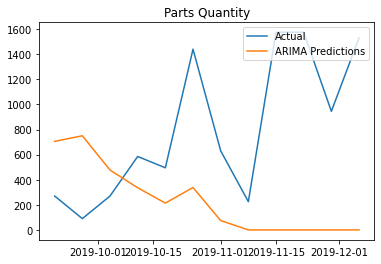

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1765.154, BIC=1789.859, Time=0.766 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1784.150, BIC=1797.874, Time=0.093 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1777.648, BIC=1794.118, Time=0.063 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1779.946, BIC=1796.416, Time=0.137 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1782.160, BIC=1793.140, Time=0.105 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1763.781, BIC=1785.740, Time=0.426 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1779.251, BIC=1798.465, Time=0.175 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1761.830, BIC=1781.044, Time=0.383 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1764.908, BIC=1786.867, Time=0.389 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1774.310, BIC=1793.

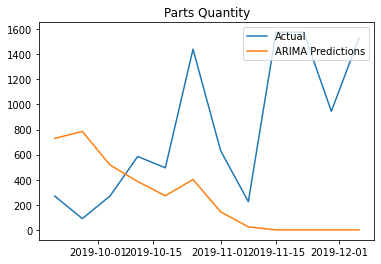

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1715.139, BIC=1739.844, Time=0.947 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1708.062, BIC=1721.787, Time=0.273 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1707.878, BIC=1724.348, Time=0.260 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1726.864, BIC=1743.333, Time=0.070 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1723.209, BIC=1734.189, Time=0.114 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1726.632, BIC=1745.846, Time=0.071 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1712.471, BIC=1731.686, Time=0.386 seconds
Near non-invertible roots for order (1, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1712.323, BIC=1734.282, Time=0.423 seconds
Near non-inver

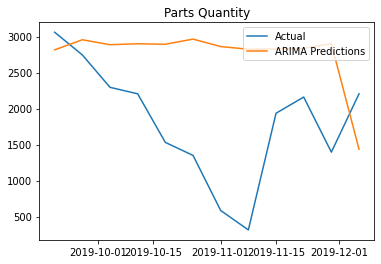

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1713.654, BIC=1738.359, Time=0.588 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1707.830, BIC=1721.555, Time=0.244 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1707.534, BIC=1724.003, Time=0.244 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1707.642, BIC=1724.111, Time=0.241 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1723.002, BIC=1733.981, Time=0.101 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1726.334, BIC=1745.548, Time=0.064 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1711.753, BIC=1730.968, Time=0.373 seconds
Near non-invertible roots for order (1, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1711.760, BIC=1733.719, Time=0.367 seconds
Near non-inver

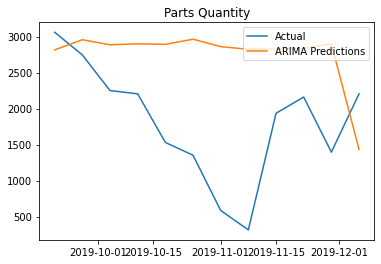

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1754.366, BIC=1779.071, Time=0.278 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1764.512, BIC=1778.237, Time=0.065 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1754.490, BIC=1770.959, Time=0.070 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1757.207, BIC=1773.676, Time=0.063 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1762.513, BIC=1773.492, Time=0.104 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1754.336, BIC=1776.296, Time=0.238 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1757.641, BIC=1776.855, Time=0.079 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1752.944, BIC=1772.159, Time=0.113 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1754.706, BIC=1776.666, Time=0.127 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1753.825, BIC=1773.

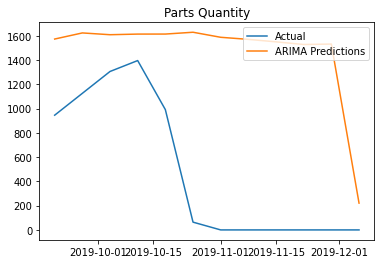

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1754.098, BIC=1778.803, Time=0.537 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1764.536, BIC=1778.260, Time=0.061 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1754.522, BIC=1770.991, Time=0.070 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1757.237, BIC=1773.707, Time=0.062 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1762.536, BIC=1773.516, Time=0.102 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1754.365, BIC=1776.325, Time=0.227 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1754.736, BIC=1776.696, Time=0.129 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1749.162, BIC=1776.612, Time=0.796 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1753.496, BIC=1778.200, Time=0.240 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1754.582, BIC=1784.

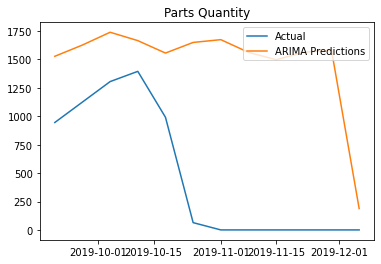

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1584.933, BIC=1612.295, Time=0.868 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1612.126, BIC=1628.543, Time=0.080 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1613.903, BIC=1633.056, Time=0.181 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1585.152, BIC=1604.305, Time=0.361 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1611.179, BIC=1624.860, Time=0.100 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1579.162, BIC=1603.788, Time=0.467 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1597.320, BIC=1621.946, Time=0.476 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too c

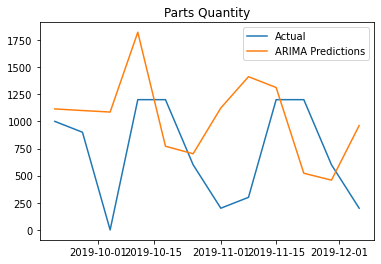

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1588.793, BIC=1616.155, Time=0.986 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1616.192, BIC=1632.609, Time=0.133 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1617.936, BIC=1637.089, Time=0.187 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1588.770, BIC=1607.923, Time=0.440 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1615.274, BIC=1628.955, Time=0.115 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1590.042, BIC=1611.931, Time=0.450 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1581.387, BIC=1603.276, Time=0.811 seconds
Near non-invertible roots for order (0, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1582.128, BIC=1606.754, Time=0.902 seconds
Near non-inver

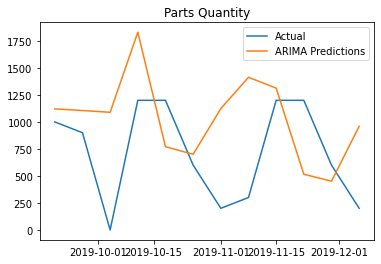

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1808.834, BIC=1836.283, Time=1.020 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1798.276, BIC=1814.746, Time=0.259 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1794.549, BIC=1813.763, Time=0.290 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1806.645, BIC=1825.859, Time=0.145 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1835.806, BIC=1849.531, Time=0.164 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1815.485, BIC=1837.445, Time=0.124 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1804.670, BIC=1826.630, Time=0.292 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1804.778, BIC=1829.482, Time=0.439 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.990)
Total fit time

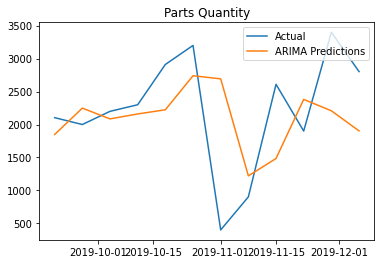

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1851.094, BIC=1875.799, Time=0.767 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1849.430, BIC=1863.155, Time=0.210 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1850.163, BIC=1866.632, Time=0.209 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1858.122, BIC=1874.592, Time=0.055 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1859.182, BIC=1870.161, Time=0.103 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1847.495, BIC=1866.709, Time=0.364 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1849.352, BIC=1871.312, Time=0.369 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1849.810, BIC=1871.770, Time=0.653 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1852.361, BIC=1871.575, Time=0.120 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1847.143, BIC=1866.

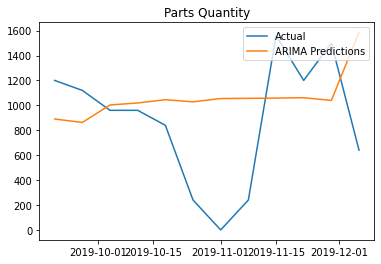

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1851.094, BIC=1875.799, Time=0.701 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1849.430, BIC=1863.155, Time=0.206 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1850.163, BIC=1866.632, Time=0.197 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1858.122, BIC=1874.592, Time=0.053 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1859.182, BIC=1870.161, Time=0.103 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1847.495, BIC=1866.709, Time=0.344 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1849.352, BIC=1871.312, Time=0.345 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1849.810, BIC=1871.770, Time=0.641 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1852.361, BIC=1871.575, Time=0.121 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1847.143, BIC=1866.

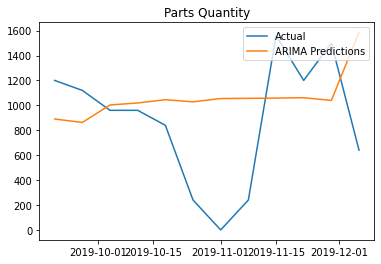

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1699.713, BIC=1727.162, Time=0.575 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1696.980, BIC=1713.450, Time=0.244 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1698.279, BIC=1717.493, Time=0.078 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1698.422, BIC=1717.637, Time=0.083 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1695.362, BIC=1709.087, Time=0.118 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1700.284, BIC=1722.244, Time=0.234 seconds
Total fit time: 1.345 seconds


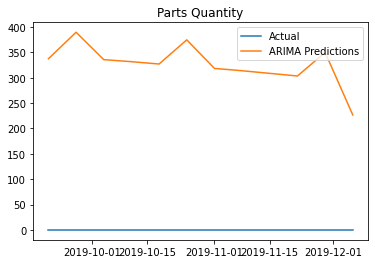

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1699.765, BIC=1727.214, Time=0.566 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1697.038, BIC=1713.507, Time=0.177 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1698.332, BIC=1717.547, Time=0.078 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1698.477, BIC=1717.691, Time=0.108 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1695.421, BIC=1709.145, Time=0.171 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1700.338, BIC=1722.297, Time=0.401 seconds
Total fit time: 1.514 seconds


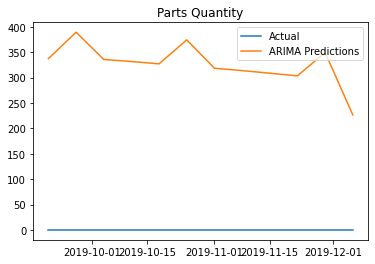

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1528.441, BIC=1555.891, Time=0.841 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1564.805, BIC=1581.274, Time=0.148 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1564.660, BIC=1583.874, Time=0.288 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1544.465, BIC=1563.679, Time=0.354 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1562.891, BIC=1576.616, Time=0.131 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1552.950, BIC=1577.654, Time=0.497 seconds
Near non-invertible roots for order (1, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1527.168, BIC=1551.872, Time=0.453 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1536.391, BIC=1558.350, Time=0.390 seconds
Near non-inver

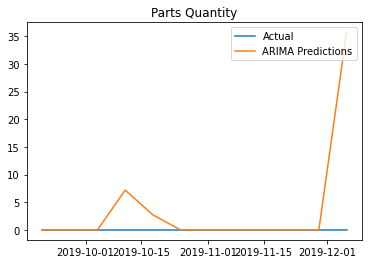

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1498.786, BIC=1526.235, Time=0.905 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1536.827, BIC=1553.296, Time=0.153 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1537.873, BIC=1557.087, Time=0.203 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1521.473, BIC=1540.687, Time=0.395 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1534.888, BIC=1548.613, Time=0.155 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1524.855, BIC=1549.559, Time=1.164 seconds
Near non-invertible roots for order (1, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1502.049, BIC=1526.754, Time=0.496 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1538.365, BIC=1568.559, Time=0.968 seconds
Near non-inver

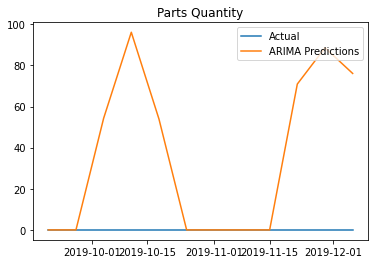

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1587.145, BIC=1614.594, Time=1.037 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1587.688, BIC=1604.157, Time=0.162 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1588.123, BIC=1607.338, Time=0.086 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1587.864, BIC=1607.079, Time=0.102 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1585.928, BIC=1599.652, Time=0.144 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1588.093, BIC=1610.052, Time=0.420 seconds
Near non-invertible roots for order (1, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Total fit time: 1.967 seconds


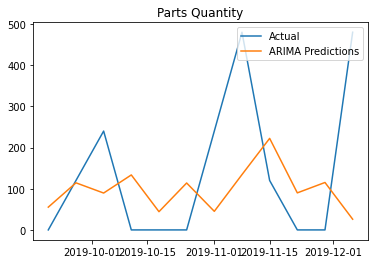

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1740.048, BIC=1764.674, Time=0.908 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1784.966, BIC=1798.647, Time=0.069 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1762.236, BIC=1778.653, Time=0.303 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1730.962, BIC=1747.379, Time=0.361 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1784.171, BIC=1795.116, Time=0.083 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1733.479, BIC=1755.369, Time=0.573 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); A

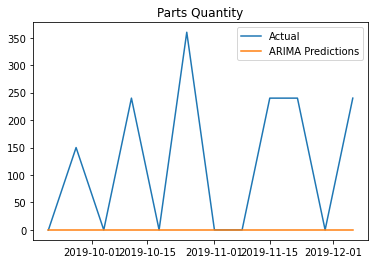

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1739.610, BIC=1764.236, Time=0.519 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1784.957, BIC=1798.638, Time=0.065 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1762.225, BIC=1778.642, Time=0.296 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1731.074, BIC=1747.491, Time=0.329 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1784.162, BIC=1795.107, Time=0.084 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1735.307, BIC=1757.196, Time=0.839 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); A

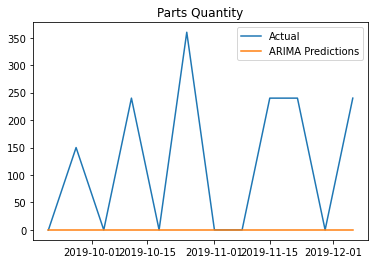

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1532.685, BIC=1560.134, Time=0.750 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1547.130, BIC=1563.600, Time=0.264 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1551.549, BIC=1570.764, Time=0.079 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1551.309, BIC=1570.524, Time=0.098 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1560.835, BIC=1574.559, Time=0.129 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1529.704, BIC=1554.409, Time=0.428 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1549.822, BIC=1571.781, Time=0.631 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1551.770, BIC=1573.729, Time=0.358 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1531.912, BIC=1559.362, Time=0.837 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1551.309, BIC=1576.

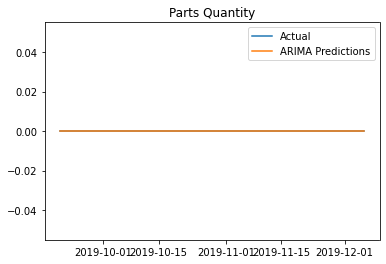

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1553.446, BIC=1580.895, Time=0.808 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1542.728, BIC=1559.198, Time=0.259 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1544.574, BIC=1563.789, Time=0.279 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1547.522, BIC=1566.737, Time=0.092 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1555.855, BIC=1569.580, Time=0.160 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1545.655, BIC=1567.615, Time=0.362 seconds
Total fit time: 1.971 seconds


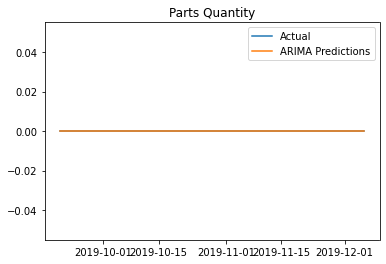

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1570.862, BIC=1595.567, Time=0.750 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1592.958, BIC=1606.683, Time=0.211 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1577.195, BIC=1593.665, Time=0.261 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1582.397, BIC=1598.867, Time=0.311 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1640.583, BIC=1651.563, Time=0.127 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1567.156, BIC=1589.115, Time=0.451 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1589.480, BIC=1608.694, Time=0.368 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1566.388, BIC=1585.602, Time=0.404 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1568.220, BIC=1590.180, Time=0.407 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1569.112, BIC=1588.

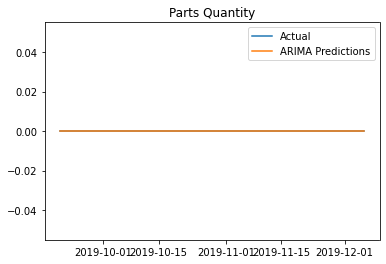

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1570.862, BIC=1595.567, Time=0.509 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1592.958, BIC=1606.683, Time=0.235 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1577.195, BIC=1593.665, Time=0.275 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1582.397, BIC=1598.867, Time=0.303 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1640.583, BIC=1651.563, Time=0.149 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1567.156, BIC=1589.115, Time=0.449 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1589.480, BIC=1608.694, Time=0.349 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1566.388, BIC=1585.602, Time=0.427 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1568.220, BIC=1590.180, Time=0.388 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1569.112, BIC=1588.

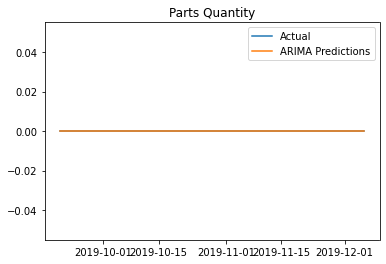

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1799.505, BIC=1824.130, Time=1.059 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1833.846, BIC=1847.527, Time=0.104 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1815.540, BIC=1831.957, Time=0.292 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1787.697, BIC=1804.114, Time=0.364 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1835.900, BIC=1846.845, Time=0.109 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1786.427, BIC=1805.580, Time=0.368 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1818.764, BIC=1840.653, Time=0.473 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1791.449, BIC=1813.339, Time=0.497 seconds
Near non-inver

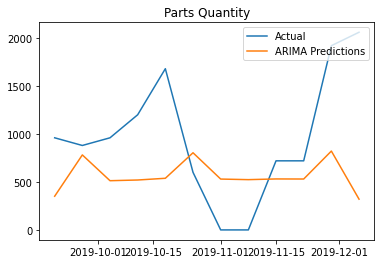

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1799.505, BIC=1824.130, Time=0.859 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1833.846, BIC=1847.527, Time=0.101 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1815.540, BIC=1831.957, Time=0.276 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1787.697, BIC=1804.114, Time=0.345 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1835.900, BIC=1846.845, Time=0.101 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1786.427, BIC=1805.580, Time=0.376 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1818.764, BIC=1840.653, Time=0.515 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1791.449, BIC=1813.339, Time=0.759 seconds
Near non-inver

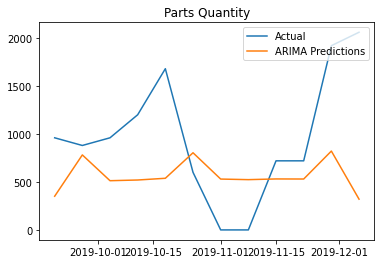

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1590.209, BIC=1614.914, Time=0.656 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1597.212, BIC=1610.936, Time=0.162 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1591.312, BIC=1607.782, Time=0.249 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1589.015, BIC=1605.485, Time=0.251 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1601.608, BIC=1612.588, Time=0.100 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1589.623, BIC=1608.837, Time=0.303 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1589.704, BIC=1608.918, Time=0.561 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1591.297, BIC=1613.256, Time=0.610 seconds
Total fit time: 2.908 seconds


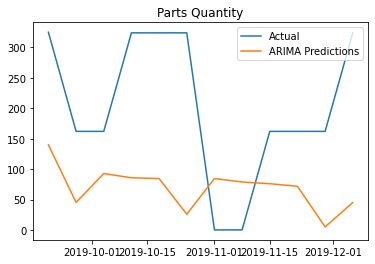

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1588.948, BIC=1613.652, Time=0.725 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1597.031, BIC=1610.756, Time=0.163 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1590.495, BIC=1606.965, Time=0.243 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1587.447, BIC=1603.916, Time=0.270 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1601.432, BIC=1612.411, Time=0.114 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1590.214, BIC=1609.428, Time=0.309 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1588.341, BIC=1607.555, Time=0.515 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1590.097, BIC=1612.056, Time=0.426 seconds
Total fit time: 2.779 seconds


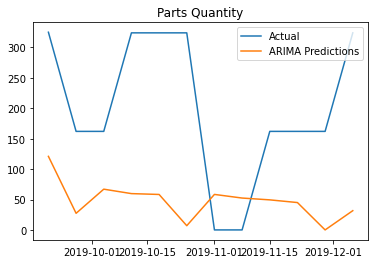

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1208.269, BIC=1232.974, Time=0.691 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1220.601, BIC=1234.326, Time=0.147 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1206.700, BIC=1223.170, Time=0.283 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1211.220, BIC=1227.690, Time=0.266 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1232.711, BIC=1243.690, Time=0.126 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1205.600, BIC=1224.814, Time=0.459 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1207.276, BIC=1229.236, Time=0.505 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1206.240, BIC=1228.200, Time=0.403 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1205.142, BIC=1224.356, Time=0.333 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1206.332, BIC=1228.

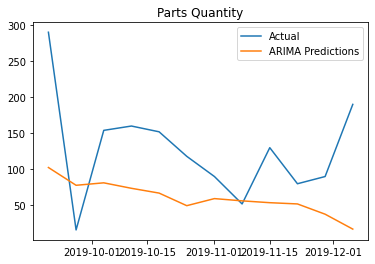

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1208.269, BIC=1232.974, Time=0.812 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1220.601, BIC=1234.326, Time=0.155 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1206.700, BIC=1223.170, Time=0.244 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1211.220, BIC=1227.690, Time=0.244 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1232.711, BIC=1243.690, Time=0.084 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1205.600, BIC=1224.814, Time=0.336 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1207.276, BIC=1229.236, Time=0.726 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1206.240, BIC=1228.200, Time=0.432 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1205.142, BIC=1224.356, Time=0.376 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1206.332, BIC=1228.

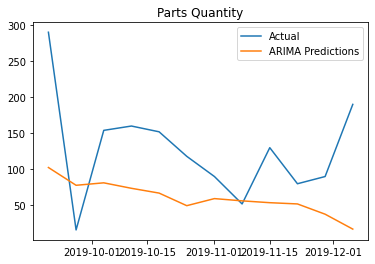

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1459.050, BIC=1483.755, Time=0.755 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1454.796, BIC=1468.521, Time=0.182 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1454.421, BIC=1470.891, Time=0.114 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1453.794, BIC=1470.263, Time=0.306 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1453.659, BIC=1464.639, Time=0.097 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1455.913, BIC=1475.128, Time=0.271 seconds
Total fit time: 1.740 seconds


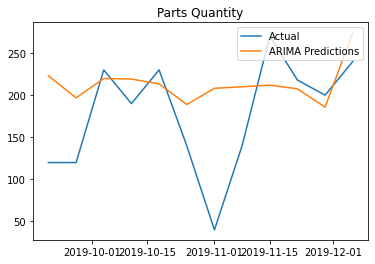

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1458.558, BIC=1483.262, Time=0.529 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1454.338, BIC=1468.063, Time=0.181 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1453.950, BIC=1470.419, Time=0.109 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1453.311, BIC=1469.781, Time=0.326 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1453.199, BIC=1464.179, Time=0.096 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1455.428, BIC=1474.643, Time=0.352 seconds
Total fit time: 1.609 seconds


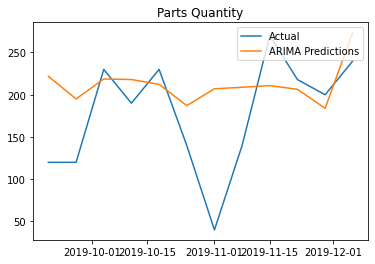

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1444.172, BIC=1468.877, Time=0.498 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1470.245, BIC=1483.969, Time=0.177 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1439.413, BIC=1455.882, Time=0.224 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1446.062, BIC=1462.532, Time=0.299 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1470.290, BIC=1481.270, Time=0.077 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1440.856, BIC=1460.070, Time=0.309 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1441.015, BIC=1460.230, Time=0.333 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1443.602, BIC=1465.562, Time=0.375 seconds
Total fit time: 2.308 seconds


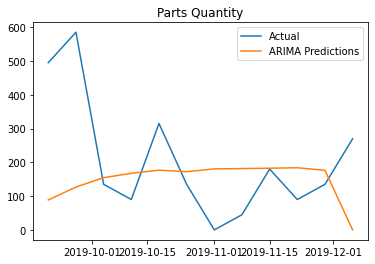

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1444.172, BIC=1468.877, Time=0.481 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1470.245, BIC=1483.969, Time=0.164 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1439.413, BIC=1455.882, Time=0.222 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1446.062, BIC=1462.532, Time=0.289 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1470.290, BIC=1481.270, Time=0.074 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1440.856, BIC=1460.070, Time=0.322 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1441.015, BIC=1460.230, Time=0.344 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1443.602, BIC=1465.562, Time=0.388 seconds
Total fit time: 2.297 seconds


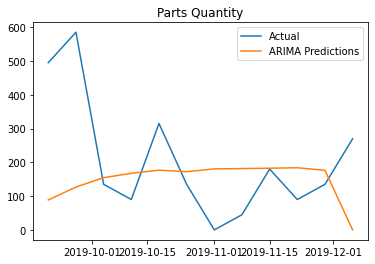

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1399.813, BIC=1424.517, Time=0.492 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1433.604, BIC=1447.328, Time=0.184 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1393.560, BIC=1410.030, Time=0.262 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1414.007, BIC=1430.476, Time=0.301 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1444.617, BIC=1455.596, Time=0.102 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1390.393, BIC=1409.607, Time=0.314 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1392.928, BIC=1414.888, Time=0.375 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1392.631, BIC=1414.591, Time=0.381 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1390.619, BIC=1409.834, Time=0.342 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1398.272, BIC=1422.

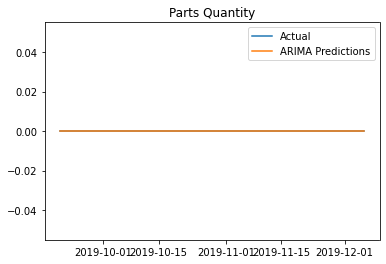

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1394.451, BIC=1419.156, Time=0.473 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1430.650, BIC=1444.375, Time=0.181 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1387.869, BIC=1404.338, Time=0.268 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1410.027, BIC=1426.497, Time=0.262 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1442.465, BIC=1453.445, Time=0.109 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1388.454, BIC=1407.668, Time=0.310 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1386.147, BIC=1405.361, Time=0.332 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1388.930, BIC=1410.889, Time=0.392 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1389.424, BIC=1411.383, Time=0.394 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1401.232, BIC=1420.

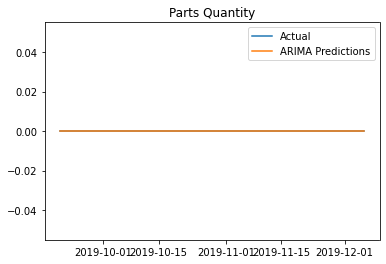

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1252.266, BIC=1279.628, Time=0.561 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1269.532, BIC=1285.949, Time=0.114 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1260.759, BIC=1279.913, Time=0.306 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1247.486, BIC=1266.639, Time=0.335 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1267.641, BIC=1281.322, Time=0.108 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1248.536, BIC=1270.426, Time=0.400 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1248.545, BIC=1270.435, Time=0.567 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1252.060, BIC=1276.685, Time=0.780 seconds
Total fit time: 3.191 seconds


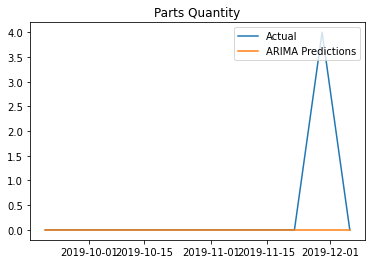

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1417.763, BIC=1442.467, Time=0.735 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1415.735, BIC=1429.460, Time=0.184 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1417.496, BIC=1433.966, Time=0.258 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1417.524, BIC=1433.994, Time=0.265 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1439.738, BIC=1450.718, Time=0.077 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1418.070, BIC=1437.284, Time=0.324 seconds
Total fit time: 1.856 seconds


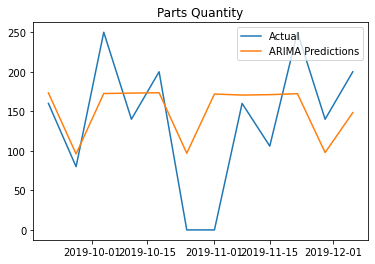

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1417.763, BIC=1442.467, Time=0.759 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1415.735, BIC=1429.460, Time=0.189 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1417.496, BIC=1433.966, Time=0.282 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1417.524, BIC=1433.994, Time=0.274 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1439.738, BIC=1450.718, Time=0.084 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1418.070, BIC=1437.284, Time=0.415 seconds
Total fit time: 2.015 seconds


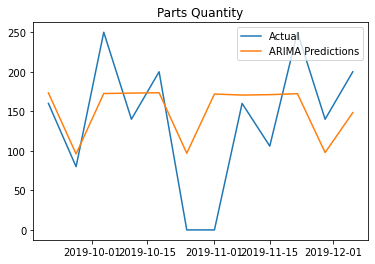

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1343.355, BIC=1368.059, Time=0.725 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1365.956, BIC=1379.681, Time=0.193 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1340.768, BIC=1357.238, Time=0.280 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1350.039, BIC=1366.508, Time=0.346 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1365.335, BIC=1376.315, Time=0.117 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1344.850, BIC=1364.065, Time=0.354 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1344.905, BIC=1364.119, Time=0.407 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1346.786, BIC=1368.745, Time=0.419 seconds
Total fit time: 2.864 seconds


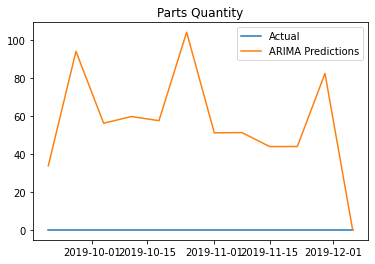

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1343.393, BIC=1368.098, Time=0.485 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1365.948, BIC=1379.672, Time=0.199 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1341.515, BIC=1357.985, Time=0.273 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1349.990, BIC=1366.460, Time=0.291 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1365.333, BIC=1376.313, Time=0.116 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1344.847, BIC=1364.061, Time=0.315 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1344.902, BIC=1364.116, Time=0.332 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1346.809, BIC=1368.769, Time=0.375 seconds
Total fit time: 2.407 seconds


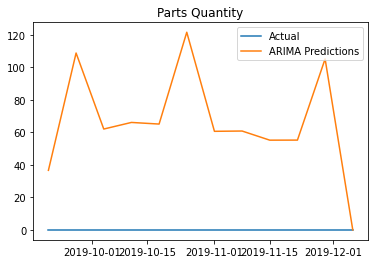

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=816.167, BIC=840.871, Time=0.789 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=811.228, BIC=824.952, Time=0.134 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=810.944, BIC=827.413, Time=0.222 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=811.003, BIC=827.473, Time=0.282 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=809.982, BIC=820.962, Time=0.085 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=812.937, BIC=832.152, Time=0.333 seconds
Total fit time: 1.857 seconds


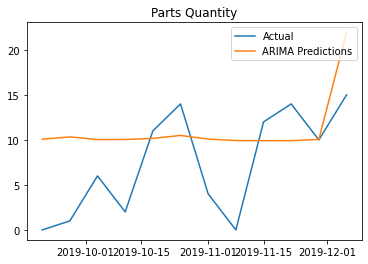

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=769.940, BIC=794.644, Time=0.501 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=765.894, BIC=779.619, Time=0.137 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=765.523, BIC=781.992, Time=0.197 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=765.420, BIC=781.889, Time=0.221 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=765.298, BIC=776.278, Time=0.092 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=767.410, BIC=786.624, Time=0.347 seconds
Total fit time: 1.510 seconds


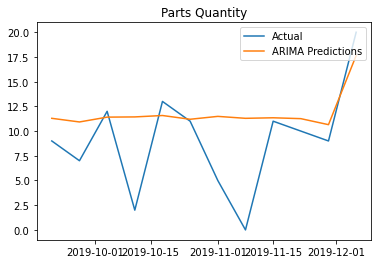

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=559.848, BIC=584.552, Time=0.813 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=554.414, BIC=568.138, Time=0.125 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=554.197, BIC=570.666, Time=0.167 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=554.072, BIC=570.541, Time=0.248 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=552.430, BIC=563.409, Time=0.082 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=556.009, BIC=575.224, Time=0.264 seconds
Total fit time: 1.713 seconds


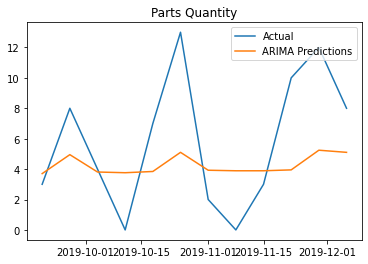

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=-90.769, BIC=-60.575, Time=0.781 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-98.742, BIC=-79.527, Time=0.539 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-96.751, BIC=-74.792, Time=0.362 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-96.752, BIC=-74.793, Time=0.355 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=-100.659, BIC=-84.190, Time=0.196 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-94.752, BIC=-70.048, Time=0.334 seconds
Total fit time: 2.580 seconds


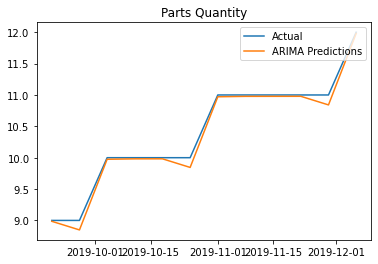

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=-2413.229, BIC=-2383.035, Time=0.229 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-2422.617, BIC=-2403.402, Time=0.162 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-2419.286, BIC=-2397.326, Time=0.132 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-2420.021, BIC=-2398.061, Time=0.148 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=-2424.617, BIC=-2408.147, Time=0.102 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-2417.300, BIC=-2392.596, Time=0.163 seconds
Total fit time: 0.948 seconds


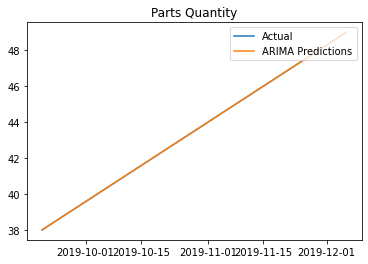

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=-127.088, BIC=-99.639, Time=0.333 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-134.717, BIC=-118.247, Time=0.152 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-133.208, BIC=-113.993, Time=0.150 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-133.128, BIC=-113.914, Time=0.244 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=294.951, BIC=308.675, Time=0.064 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-131.214, BIC=-109.254, Time=0.274 seconds
Total fit time: 1.229 seconds


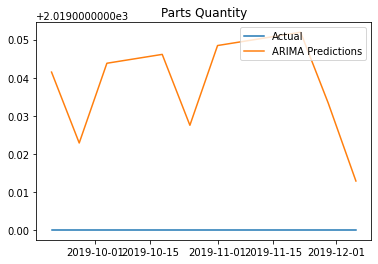

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-4.117, BIC=20.509, Time=0.463 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=20.978, BIC=34.659, Time=0.097 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=0.290, BIC=16.707, Time=0.184 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-33.989, BIC=-17.571, Time=0.285 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=18.978, BIC=29.923, Time=0.088 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-33.100, BIC=-13.946, Time=0.351 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-22.961, BIC=-3.808, Time=0.564 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-22.820, BIC=-0.930, Time=0.684 seconds
Total fit time: 2.733 seconds


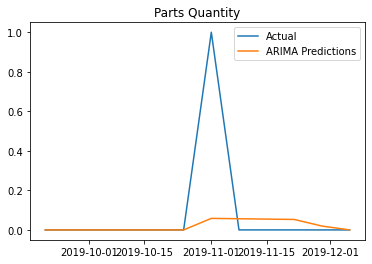

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=-94.057, BIC=-69.352, Time=0.847 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-101.759, BIC=-88.034, Time=0.147 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-99.815, BIC=-83.346, Time=0.152 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-99.814, BIC=-83.344, Time=0.175 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=-101.916, BIC=-90.936, Time=0.099 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-97.883, BIC=-78.669, Time=0.311 seconds
Total fit time: 1.744 seconds


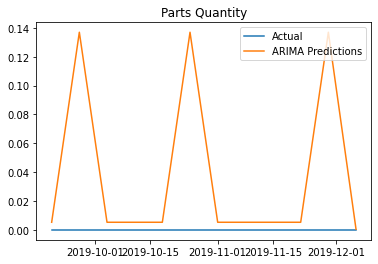

AVERAGE WMAPE SCORE:  71.09
MEDIAN WMAPE SCORE:  68.36


'                           The End                                  '

In [68]:


# define an empty wmape, rmse list
wmape_list = []
rmse_list = []

'''                  For loop start here                               '''

for parts in range(0,len(df_final)):
    
    try:
    
        # extract individal time series
        df_model = df_final.iloc[parts,:]
        
        # converting to datetime and renaming columns
        df_model.index = pd.to_datetime(df_model.index)
        df_model = df_model.reset_index()
        df_model.columns = ['date','Quantity']
    
    
        '''                           Feature engineering                  '''
        # 1. month
        df_model['Month']= df_model['date'].dt.month 
        
        # 2. Day
        df_model['Day'] = df_model['date'].dt.day
        
        # 3. Year
        df_model['Year'] = df_model['date'].dt.year
        
        # 4. MonthYear
        df_model['Month year'] = df_model.apply(lambda x: str(x['Month']) + "/" + 
                                                str(x['Year']), axis = 1)
        
        # 5. lag
        # find pacf correaltion array
        corr_values = pacf(df_model['Quantity'], nlags=52)
        
        # filter correlation only greater than 60%
        corr_indices = np.argwhere(corr_values > 0.6)[:,0].tolist()
        
        # filter out indix = 0 as it is self-correaltion
        corr_indices = list(filter(lambda num: num != 0, corr_indices))
        
        # creating shift features based on correaltion greater than 60%
        for i in corr_indices: 
            df_model['Lag_' + str(i)] = df_model['Quantity'].shift(i)
        
        # 6. quarter flag
        #df_model['Quarter end flag'] = df_model.apply(lambda x: 1 if x['Month'] in [3,6,9,12] else 0, axis = 1)
        
        # 7. half yearly flag
        df_model_month_summ = df_model.groupby(['Month year']).agg({'Day':['max']}).reset_index()
        df_model_month_summ.columns = ['Month year','Last day']
        df_model = pd.merge(df_model,df_model_month_summ, on = 'Month year',
                            how = 'left')
        df_model['Half year'] = df_model.apply(lambda x: 1 if (x['Day'] == x['Last day']) & ((x['Month'] == 6) | (x['Month']==12)) else 0, axis = 1)
        
        # 8. month end flag
        df_model['Month end'] = df_model.apply(lambda x: 1 if (x['Day'] == x['Last day'])else 0, axis = 1)
    
        # 9. rolling mean - justification needed?
        df_model['Rolling mean'] = df_model['Quantity'].rolling(80).mean()
        df_model = df_model.dropna()
        
        # drop Month, Day, Year, Month year and Last day columns - useless. 
        df_model = df_model.drop(columns = ['Day','Year','Month','Month year', 'Last day'])
        
        # set back index
        df_model = df_model.set_index('date')
        
        # sorting data descending
        df_model = df_model.sort_index(axis = 0)
        df_model = df_model
        
        '''                        Model Pre-processing                    '''
        
        # target, predictor split
        X = df_model.iloc[:,1:]
        Y = df_model.iloc[:,0]
        
        # train-test splitting
        X_train = X.head(len(X)-12)
        X_test = X.tail(12)
        
        Y_train = Y.head(len(Y)-12)
        Y_test = Y.tail(12)
          
        # creating a evaluation dataframe - to save test results
        df_evaluation = pd.DataFrame(Y_test).reset_index()
        df_evaluation = df_evaluation.rename(columns={'Quantity':'Actuals'})
        
        '''                            Model Run                           '''
        modl = pm.auto_arima(Y_train,
                             stepwise = True,
                             trace = True,
                             seasonal = False,
                             exogenous = X_train,
                             error_action='ignore')
        
        # Create predictions for the future, evaluate on test
        preds = modl.predict(n_periods=12,exogenous = X_test)
        
        # replace negative predictions with zeroes as quantities cannot be negative
        preds[preds < 0] = 0
        preds = pd.DataFrame(preds)
        
        '''                           Evaluation                           '''
        # evaluation
        df_evaluation = pd.concat([df_evaluation,pd.DataFrame(preds)],axis = 1)
        df_evaluation = df_evaluation.rename(columns={0: 'ARIMA'})
        rmse_error = round(rmse(df_evaluation['Actuals'], df_evaluation['ARIMA']),2)
        wmape_error = round(abs(df_evaluation['Actuals'] - df_evaluation['ARIMA']).sum(axis=0) * 100/ df_evaluation['Actuals'].sum(axis=0),2)
        
        # saving each series's wmapr in a list
        wmape_list.append(wmape_error)
        rmse_list.append(rmse_error)
        
        # plotting results
        plt.plot(df_evaluation['date'],df_evaluation['Actuals'],label = 'Actual')
        plt.plot(df_evaluation['date'],df_evaluation['ARIMA'],label = 'ARIMA Predictions')
        plt.legend(loc = 'upper right')
        plt.title('Parts Quantity')
        plt.show()
    
    except:
        pass

# remove nan and infinity from list -check why occuring?
from math import isnan, isinf
wmape_list = [v for v in wmape_list if not isnan(v) and not isinf(v)]

# print mean of list
print("AVERAGE WMAPE SCORE: ", round(np.mean(wmape_list),2))
print("MEDIAN WMAPE SCORE: ", round(np.median(wmape_list),2))


'''                           The End                                  '''